# Learning Coefficients

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

if not "AWS_ACCESS_KEY_ID" in os.environ or not "AWS_SECRET_ACCESS_KEY" in os.environ:
    raise Exception("AWS_ACCESS_KEY_ID or AWS_SECRET_ACCESS_KEY not found in environment variables. Please set them in .env file.")

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pprint import pp
from pathlib import Path
from typing import Optional, Iterable, List, Tuple, Dict, Union, Callable
import warnings

import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
from torch import nn
import wandb
import matplotlib.pyplot as plt
import pandas as pd

import devinterp
import devinfra
from devinfra.utils.iterables import filter_objs

# del sys.modules['icl.analysis.utils']
from icl.analysis.utils import wandb_runs_to_df
from icl.constants import SWEEPS, FIGURES, ANALYSIS
from icl.analysis.utils import get_unique_run

sns.set_theme(style="whitegrid")

api= wandb.Api()

from icl.constants import FIGURES, ANALYSIS
from icl.setup import DEVICE

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## Set-up

In [3]:
from icl.analysis.utils import get_sweep_configs

NUM_LAYERS = 2
NUM_HEADS = 4
LR = 0.01

TRAINING_SWEEP_ID = "n698i1jy"
TRAINING_SWEEP_FILENAME = "training-runs/small-L-2.yaml"

filters = {"task_config": {"num_layers": NUM_LAYERS, "num_heads": NUM_HEADS}, "optimizer_config": {"lr": LR}}  # TODO: Where are the H=2 runs?
configs = list(get_sweep_configs(SWEEPS / TRAINING_SWEEP_FILENAME, **filters))

print(f"Found {len(configs)} runs.")

Found 21 runs.


/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(


In [4]:
# Figure out which checkpoints are available

checkpointers = [config.checkpointer_config.factory() for config in tqdm(configs, desc="Reading checkpoints")]

for checkpointer in tqdm(checkpointers, desc="Loading checkpoints"):
    print(f"Found {len(checkpointer.file_ids)} checkpoints for {checkpointer}")

Reading checkpoints:   0%|          | 0/21 [00:00<?, ?it/s]

Loading checkpoints: 100%|██████████| 21/21 [00:00<00:00, 14653.20it/s]

Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-2-task-7ed30b-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-4-task-871f4f-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-8-task-6d414c-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-16-task-fef7aa-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-32-task-b02901-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-64-

In [5]:
MS = [config.task_config.num_tasks for config in configs] # [1, 4, 64, 2**10, 2**20]
STEPS = checkpointer.file_ids

# Calibrating LLCs

Let's look at finding the right hyperparameters for learning coefficient estimation

## Evaluation Dataset

### Evaluation Dataset Size

In [14]:
FORCE_REEVAL = False

EVAL_DATASET_SIZE_SWEEP_NAME = "eval-dataset-size"
EVAL_DATASET_SIZE_SWEEP_ID = "kgw0k98p"

if not os.path.exists(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_dataset_size_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_DATASET_SIZE_SWEEP_ID}")
        eval_dataset_size_runs = list(filter_objs([r for r in eval_dataset_size_sweep.runs], config=filters))
        eval_dataset_size_df = wandb_runs_to_df(eval_dataset_size_runs)
    
    eval_dataset_size_df.to_pickle(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME)

else:
    eval_dataset_size_df = pd.read_pickle(ANALYSIS / EVAL_DATASET_SIZE_SWEEP_NAME)

columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

# Convert each column to numeric, coercing "NaN" strings to actual NaN values
for col in columns_to_convert:
    eval_dataset_size_df[col] = pd.to_numeric(eval_dataset_size_df[col], errors='coerce')

eval_dataset_size_df.reset_index(inplace=True)


eval_dataset_size_df['log_num_tasks'] = np.log2(eval_dataset_size_df['task_config/num_tasks'])
eval_dataset_size_df

,index,num_training_samples,batch_size,run_name,num_steps,optimizer_config/optimizer_type,optimizer_config/lr,optimizer_config/weight_decay,optimizer_config/momentum,optimizer_config/betas,...,wbic/mean,loss/mean,_timestamp,llc/std,_runtime,llc/mean,_step,wbic/std,loss/std,log_num_tasks
0,0,128000000,256,ntasks-16384-task-e30fe5-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,61.478325,0.001876,1.702276e+09,0.022329,20265.628519,0.048633,10.0,2.150922,0.000066,14.0
1,1,128000000,256,ntasks-16384-task-e30fe5-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,62.389957,0.001904,1.702276e+09,0.022418,20274.224884,0.058096,20.0,2.159531,0.000066,14.0
2,2,128000000,256,ntasks-16384-task-e30fe5-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,63.017208,0.001923,1.702276e+09,0.021143,20283.180155,0.064608,30.0,2.036711,0.000062,14.0
3,3,128000000,256,ntasks-16384-task-e30fe5-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,63.584320,0.001940,1.702276e+09,0.021470,20291.701798,0.070495,40.0,2.068174,0.000063,14.0
4,4,128000000,256,ntasks-16384-task-e30fe5-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,64.149521,0.001958,1.702276e+09,0.022951,20300.051419,0.076362,50.0,2.210813,0.000067,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11895,95,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.244400,0.000239,1.702105e+09,0.091775,1284.196701,0.038396,960.0,0.276271,0.000270,0.0
11896,96,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.244539,0.000239,1.702105e+09,0.091804,1284.678999,0.038443,970.0,0.276358,0.000270,0.0
11897,97,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.245739,0.000240,1.702105e+09,0.092823,1285.178665,0.038841,980.0,0.279426,0.000273,0.0
11898,98,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.246056,0.000240,1.702105e+09,0.093071,1285.789300,0.038947,990.0,0.280171,0.000274,0.0


In [15]:
eval_datasets_sizes = sorted(eval_dataset_size_df['sampler_config/eval_dataset_size'].unique())[:-1]
eval_datasets_sizes


[1024, 2048, 4096, 8192, 16384]

<ipython-input-16-e388c6199f95>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])


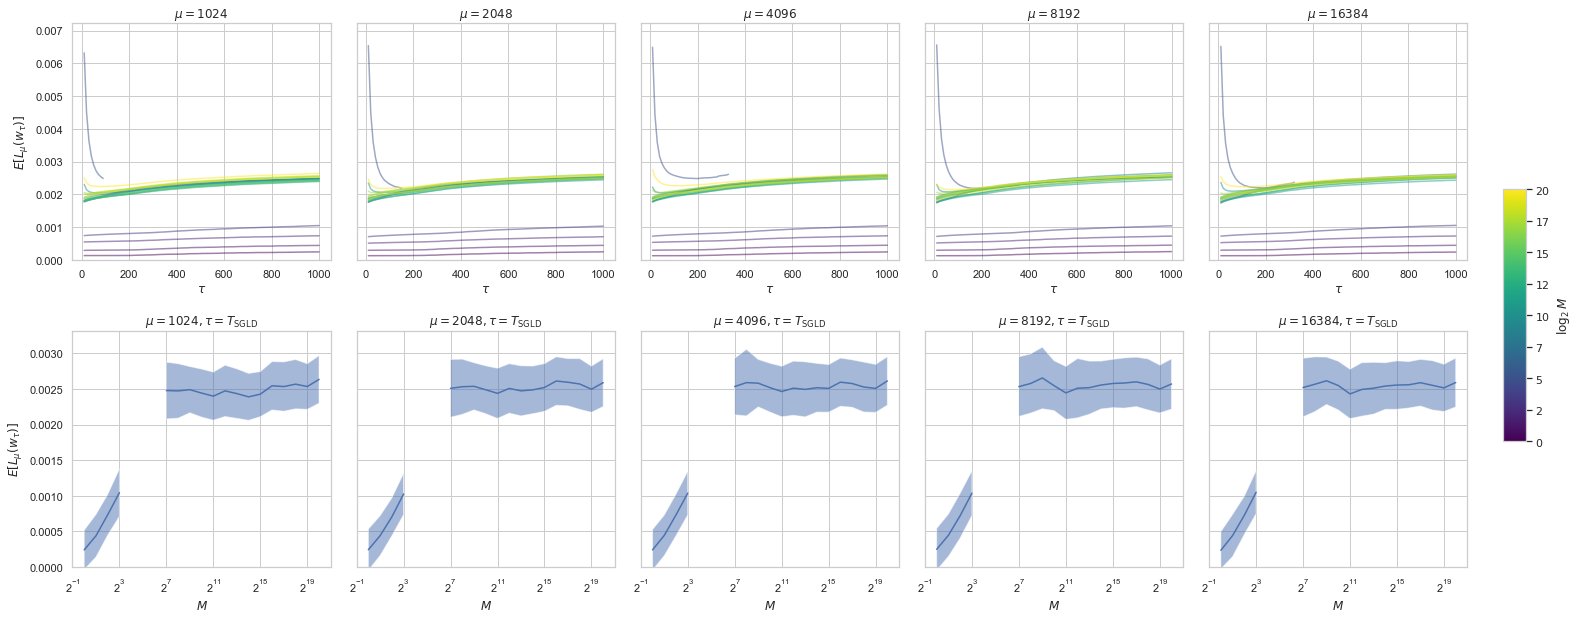

In [16]:
fig, axes = plt.subplots(2, len(eval_datasets_sizes), figsize=(5*len(eval_datasets_sizes), 10))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

max_loss_over_time = eval_dataset_size_df['loss/mean'].max()
max_loss_at_end = eval_dataset_size_df[eval_dataset_size_df['_step'] == eval_dataset_size_df['_step'].max()]['loss/mean'].max()

for i, (ax1, ax2, eval_dataset_size) in enumerate(zip(axes[0, :], axes[1, :], eval_datasets_sizes)):
    _df = eval_dataset_size_df.loc[eval_dataset_size_df['sampler_config/eval_dataset_size'] == eval_dataset_size]

    sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)

    ax1.set_title(f"$\mu = {eval_dataset_size}$")
    ax1.set_xlabel(r"$\tau$")
    ax1.legend().remove()
    ax1.set_ylim(0, max_loss_over_time * 1.1)

    _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

    ax2.plot(_final_df['task_config/num_tasks'], _final_df['loss/mean'], alpha=1)
    ax2.fill_between(_final_df["task_config/num_tasks"], _final_df["loss/mean"] - _final_df["loss/std"], _final_df["loss/mean"] + _final_df["loss/std"], alpha=0.5)

    ax2.set_title(fr"$\mu = {eval_dataset_size}, \tau = T_\mathrm{{SGLD}}$")
    ax2.set_xlabel(r"$M$")
    ax2.set_xscale('log', base=2)

    ax2.set_ylim(0, max_loss_at_end * 1.25)

    if i > 0:
        ax1.set_yticklabels([])
        ax1.set_ylabel("")
        ax2.set_yticklabels([])
        ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")
axes[1, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")

# Add a colorbar for the hues on the left side of the top row
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=_df["log_num_tasks"].min(), vmax=_df["log_num_tasks"].max()))
sm._A = []  # Fake up the array of the scalar mappable
cb_ax = fig.add_axes([0.92, 0.3, 0.0125, 0.35])  # Adjust these values as needed for positioning and size
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])
cbar.set_label('$\log_2 M$')  # Update this label as needed

fig.set_facecolor('white')

### Fixed Evaluation Datasets


In [17]:
FORCE_REEVAL = True

EVAL_FIXED_BATCH_SWEEP_NAME = "fixed-batch"
EVAL_FIXED_BATCH_SWEEP_ID = "rhjocgp2"

if not os.path.exists(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_fixed_batch_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_FIXED_BATCH_SWEEP_ID}")
        eval_fixed_batch_runs = list(filter_objs([r for r in eval_fixed_batch_sweep.runs], config=filters))
        eval_fixed_batch_df = wandb_runs_to_df(eval_fixed_batch_runs)
    
    eval_fixed_batch_df.to_pickle(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME)

else:
    eval_fixed_batch_df = pd.read_pickle(ANALYSIS / EVAL_FIXED_BATCH_SWEEP_NAME)

columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

for col in columns_to_convert:
    eval_fixed_batch_df[col] = pd.to_numeric(eval_fixed_batch_df[col], errors='coerce')


eval_fixed_batch_df.reset_index(inplace=True)
eval_fixed_batch_df['log_num_tasks'] = np.log2(eval_fixed_batch_df['task_config/num_tasks'])
eval_fixed_batch_df

Converting runs to dfs:   0%|          | 0/5 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Converting runs to dfs:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python

,index,wbic/mean,_timestamp,loss_trace,wbic/std,llc/std,loss/std,loss/mean,_runtime,llc/mean,...,sampler_config/grad_batch_size,sampler_config/sampling_method,sampler_config/eval_dataset_size,sampler_config/grad_batch_origin,sampler_config/localization_scale,plotting_config/num_points,plotting_config/num_components,plotting_config/include_loss_trace,plotting_config/include_weights_pca,log_num_tasks
0,0,NaN,1.702690e+09,None,NaN,NaN,NaN,NaN,1529.145714,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,20.0
1,1,NaN,1.702690e+09,None,NaN,NaN,NaN,NaN,1529.870193,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,20.0
2,2,NaN,1.702690e+09,None,NaN,NaN,NaN,NaN,1530.419271,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,20.0
3,3,NaN,1.702690e+09,None,NaN,NaN,NaN,NaN,1530.972876,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,20.0
4,4,NaN,1.702690e+09,None,NaN,NaN,NaN,NaN,1531.687850,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,95,NaN,1.702683e+09,None,NaN,NaN,NaN,NaN,1433.970655,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,0.0
496,96,NaN,1.702683e+09,None,NaN,NaN,NaN,NaN,1434.489382,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,0.0
497,97,NaN,1.702683e+09,None,NaN,NaN,NaN,NaN,1434.998108,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,0.0
498,98,NaN,1.702683e+09,None,NaN,NaN,NaN,NaN,1435.658548,NaN,...,1024,sgld,1048576,eval-dataset,0.00015,10,3,True,True,0.0


In [18]:
eval_fixed_batch_df.columns

Index(['index', 'wbic/mean', '_timestamp', 'loss_trace', 'wbic/std', 'llc/std',
       'loss/std', 'loss/mean', '_runtime', 'llc/mean', '_step',
       'num_training_samples', 'batch_size', 'run_name', 'num_steps',
       'optimizer_config/optimizer_type', 'optimizer_config/lr',
       'optimizer_config/weight_decay', 'optimizer_config/momentum',
       'optimizer_config/betas', 'optimizer_config/noise_level',
       'optimizer_config/elasticity', 'optimizer_config/temperature',
       'optimizer_config/num_samples', 'scheduler_config/scheduler_type',
       'scheduler_config/step_size', 'scheduler_config/gamma',
       'scheduler_config/T_max', 'scheduler_config/eta_min',
       'scheduler_config/last_epoch', 'scheduler_config/milestones',
       'scheduler_config/lr_lambda', 'scheduler_config/max_lr',
       'scheduler_config/total_steps', 'scheduler_config/anneal_strategy',
       'scheduler_config/div_factor', 'scheduler_config/final_div_factor',
       'scheduler_config/pct_start'

In [19]:
validation_batch_sizes = np.array([2 ** i for i in range(10, 14)])
validation_batch_sizes

array([1024, 2048, 4096, 8192])

KeyError: 'y'

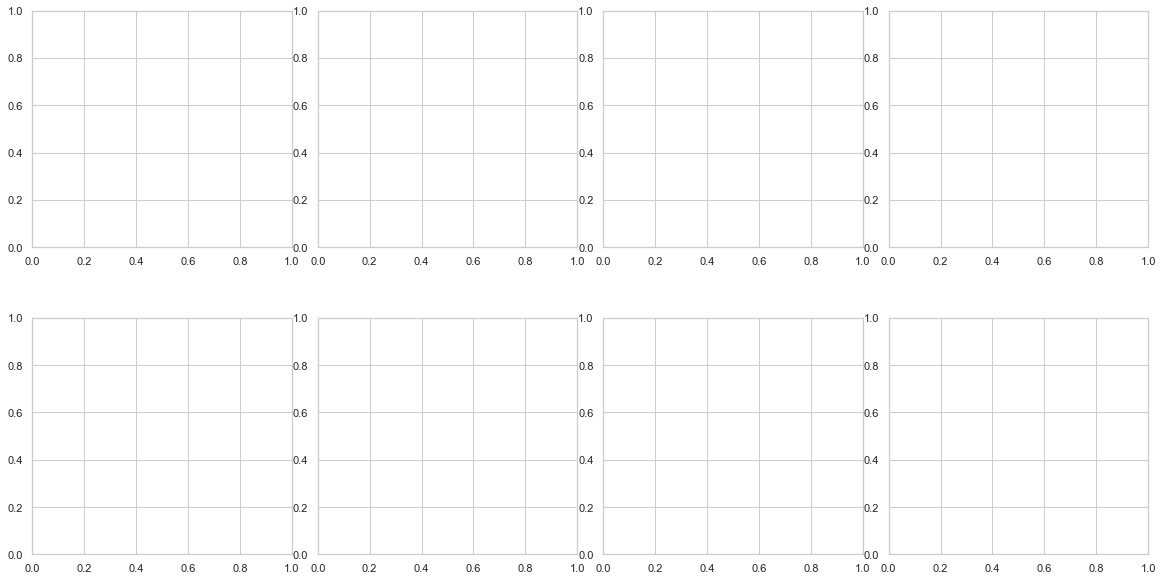

In [22]:
fig, axes = plt.subplots(2, len(validation_batch_sizes), figsize=(5*len(validation_batch_sizes), 10))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

max_loss_over_time = eval_fixed_batch_df['loss/mean'].max() 
max_loss_at_end = eval_fixed_batch_df[eval_fixed_batch_df['_step'] == eval_fixed_batch_df['_step'].max()]['loss/mean'].max() 


for i, (ax1, ax2, eval_batch_size) in enumerate(zip(axes[0, :], axes[1, :], validation_batch_sizes)):
    _df = eval_fixed_batch_df.loc[eval_fixed_batch_df['sampler_config/eval_batch_size'] == eval_batch_size]

    sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)

    ax1.set_title(f"$\mu = {eval_batch_size}$")
    ax1.set_xlabel(r"$\tau$")
    ax1.legend().remove()
    ax1.set_ylim(0, max_loss_over_time * 1.1)

    _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

    ax2.plot(_final_df['task_config/num_tasks'], _final_df['loss/mean'], alpha=1)
    ax2.fill_between(_final_df["task_config/num_tasks"], _final_df["loss/mean"] - _final_df["loss/std"], _final_df["loss/mean"] + _final_df["loss/std"], alpha=0.5)

    ax2.set_title(fr"$\mu = {eval_batch_size}, \tau = T_\mathrm{{SGLD}}$")
    ax2.set_xlabel(r"$M$")
    ax2.set_xscale('log', base=2)

    ax2.set_ylim(0, max_loss_at_end * 1.25)

    if i > 0:
        ax1.set_yticklabels([])
        ax1.set_ylabel("")
        ax2.set_yticklabels([])
        ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")
axes[1, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")

# Add a colorbar for the hues on the left side of the top row
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=_df["log_num_tasks"].min(), vmax=_df["log_num_tasks"].max()))
sm._A = []  # Fake up the array of the scalar mappable
cb_ax = fig.add_axes([0.92, 0.3, 0.0125, 0.35])  # Adjust these values as needed for positioning and size
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])
cbar.set_label('$\log_2 M$')  # Update this label as needed

fig.set_facecolor('white')

### Minibatch Evaluation Datasets

In [23]:
FORCE_REEVAL = True

EVAL_MINIBATCH_SWEEP_NAME = "mini-batch"
EVAL_MINIBATCH_SWEEP_ID = "1egni31s"

if not os.path.exists(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_minibatch_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_MINIBATCH_SWEEP_ID}")
        eval_minibatch_runs = list(filter_objs([r for r in eval_minibatch_sweep.runs], config=filters))
        eval_minibatch_df = wandb_runs_to_df(eval_minibatch_runs)
    
    eval_minibatch_df.to_pickle(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME)

else:
    eval_minibatch_df = pd.read_pickle(ANALYSIS / EVAL_MINIBATCH_SWEEP_NAME)

columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

for col in columns_to_convert:
    eval_minibatch_df[col] = pd.to_numeric(eval_minibatch_df[col], errors='coerce')


eval_minibatch_df.reset_index(inplace=True)
eval_minibatch_df['log_num_tasks'] = np.log2(eval_minibatch_df['task_config/num_tasks'])
eval_minibatch_df

Converting runs to dfs:   0%|          | 0/54 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Converting runs to dfs:   2%|▏         | 1/54 [00:00<00:26,  1.98it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/pyth

,index,num_training_samples,batch_size,run_name,num_steps,optimizer_config/optimizer_type,optimizer_config/lr,optimizer_config/weight_decay,optimizer_config/momentum,optimizer_config/betas,...,llc/mean,wbic/mean,_runtime,llc/std,loss/mean,loss/std,wbic/std,_timestamp,loss_trace,log_num_tasks
0,0,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.561721,132849.312500,2943.324017,0.704840,0.126695,0.002072,2172.703369,1.702747e+09,NaN,0.0
1,1,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.822696,133653.781250,2945.284708,0.959220,0.127462,0.002820,2956.841553,1.702747e+09,NaN,0.0
2,2,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,0.898602,133887.765625,2947.411211,0.961352,0.127685,0.002826,2963.414307,1.702747e+09,NaN,0.0
3,3,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,1.027615,134285.453125,2949.625133,1.149063,0.128065,0.003378,3542.040039,1.702747e+09,NaN,0.0
4,4,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,1.102609,134516.625000,2951.707273,1.207684,0.128285,0.003550,3722.743164,1.702747e+09,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5295,95,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,392.883779,NaN,NaN,NaN,NaN,1.702683e+09,None,10.0
5296,96,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,393.031409,NaN,NaN,NaN,NaN,1.702683e+09,None,10.0
5297,97,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,393.174455,NaN,NaN,NaN,NaN,1.702683e+09,None,10.0
5298,98,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,393.315455,NaN,NaN,NaN,NaN,1.702683e+09,None,10.0


In [24]:
grad_batch_sizes = [256, 512, 1024, 2048, 4096, 8192]

<ipython-input-42-b77a95eacc50>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])


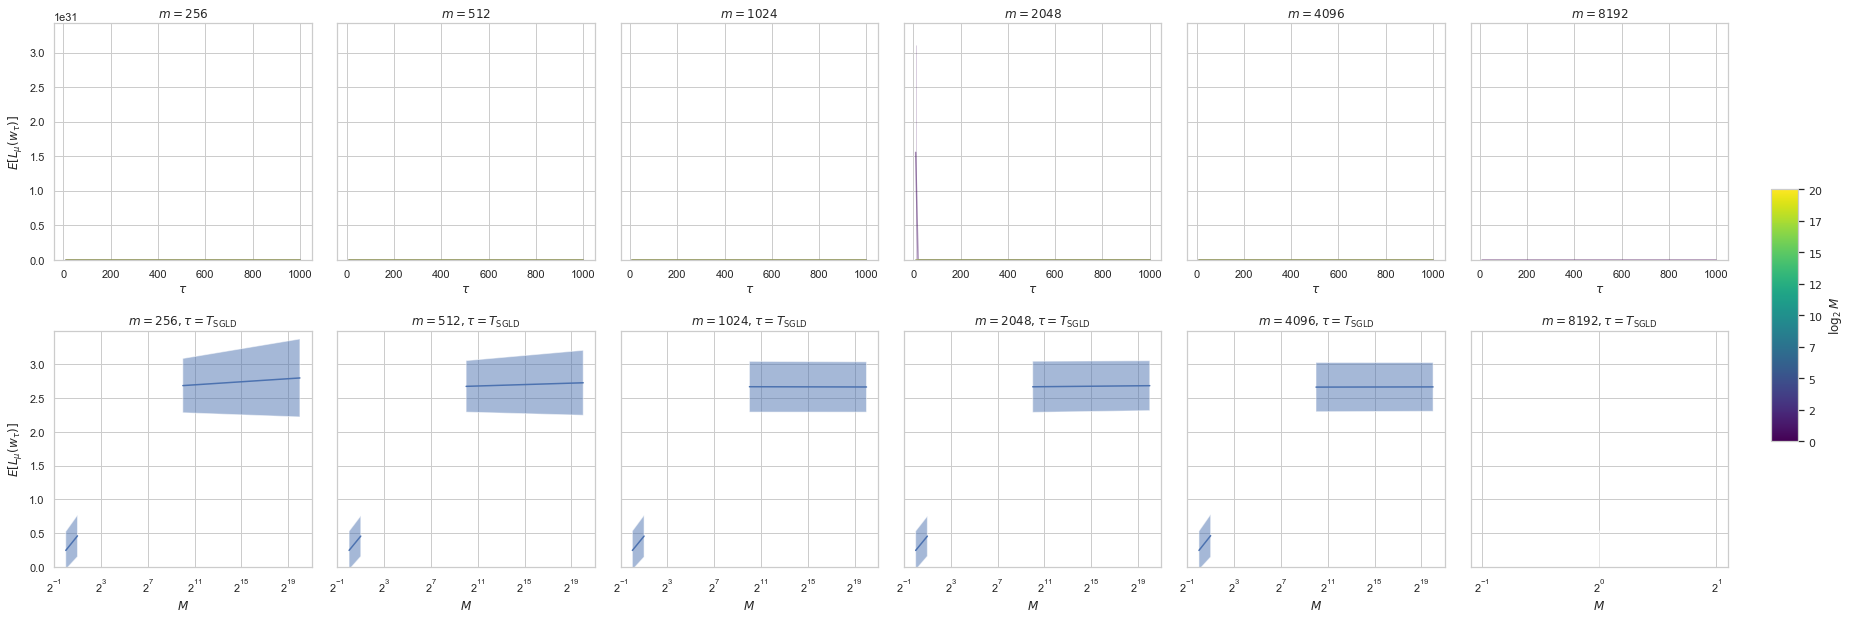

<ipython-input-42-b77a95eacc50>:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: Axis limits cannot be NaN or Inf

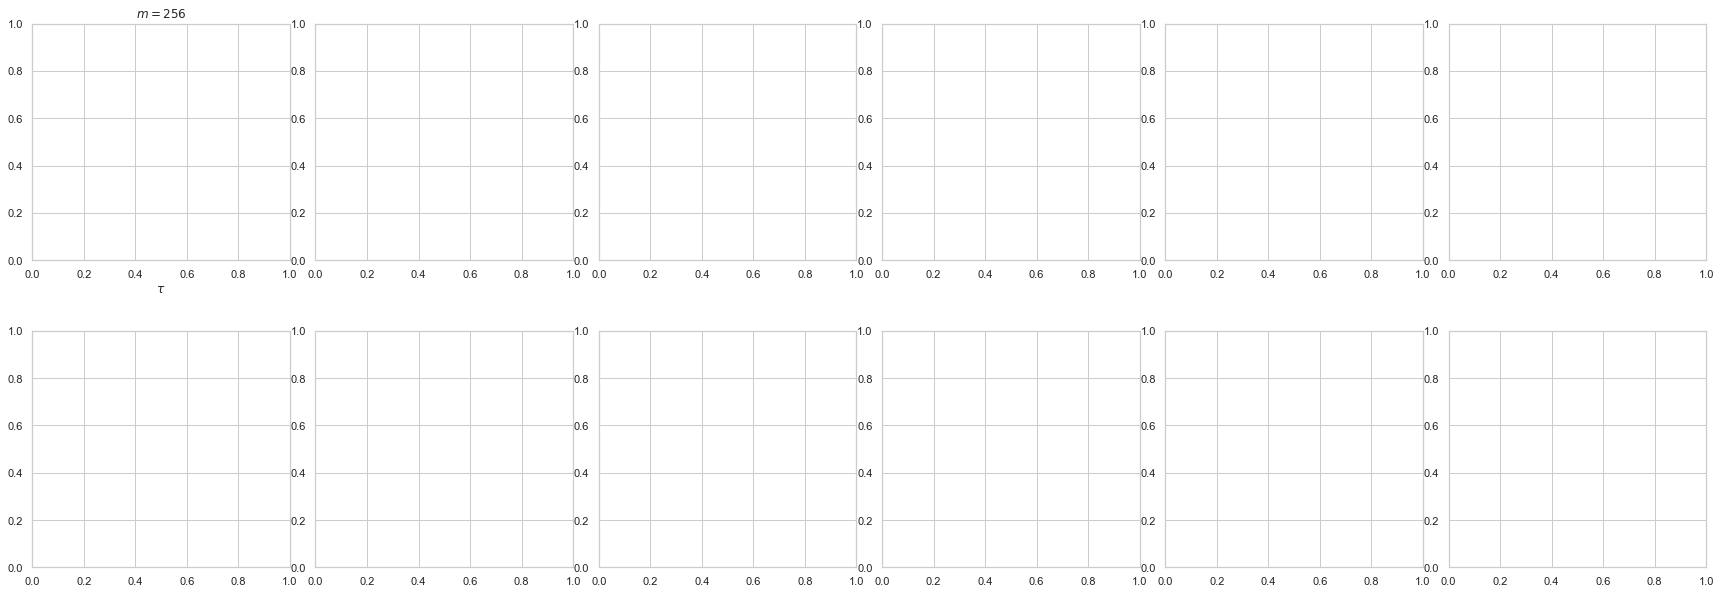

In [42]:

for eval_method in ['grad-minibatch', 'new-minibatch']:
    fig, axes = plt.subplots(2, len(grad_batch_sizes), figsize=(5*len(grad_batch_sizes), 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

    _eval_grad_minibatch_df = eval_minibatch_df.loc[eval_minibatch_df['sampler_config/eval_method'] == eval_method]

    max_loss_over_time = _eval_grad_minibatch_df['loss/mean'].max() 
    max_loss_at_end = _eval_grad_minibatch_df[_eval_grad_minibatch_df['_step'] == _eval_grad_minibatch_df['_step'].max()]['loss/mean'].max() 

    for i, (ax1, ax2, grad_batch_size) in enumerate(zip(axes[0, :], axes[1, :], grad_batch_sizes)):
        _df = _eval_grad_minibatch_df.loc[_eval_grad_minibatch_df['sampler_config/grad_batch_size'] == grad_batch_size]

        sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)

        ax1.set_title(f"$m = {grad_batch_size}$")
        ax1.set_xlabel(r"$\tau$")
        ax1.legend().remove()
        ax1.set_ylim(0, max_loss_over_time * 1.1)

        _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

        ax2.plot(_final_df['task_config/num_tasks'], _final_df['loss/mean'], alpha=1)
        ax2.fill_between(_final_df["task_config/num_tasks"], _final_df["loss/mean"] - _final_df["loss/std"], _final_df["loss/mean"] + _final_df["loss/std"], alpha=0.5)

        ax2.set_title(fr"$m = {grad_batch_size}, \tau = T_\mathrm{{SGLD}}$")
        ax2.set_xlabel(r"$M$")
        ax2.set_xscale('log', base=2)

        ax2.set_ylim(0, max_loss_at_end * 1.25)

        if i > 0:
            ax1.set_yticklabels([])
            ax1.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.set_ylabel("")

    axes[0, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")
    axes[1, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")

    # Add a colorbar for the hues on the left side of the top row
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=_df["log_num_tasks"].min(), vmax=_df["log_num_tasks"].max()))
    sm._A = []  # Fake up the array of the scalar mappable
    cb_ax = fig.add_axes([0.92, 0.3, 0.0125, 0.35])  # Adjust these values as needed for positioning and size
    cbar = fig.colorbar(sm, cax=cb_ax)
    cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])
    cbar.set_label('$\log_2 M$')  # Update this label as needed

    fig.set_facecolor('white')

    plt.show()

## Evaluation Loss Function

In [ ]:
FORCE_REEVAL = True

EVAL_LOSS_FN_SWEEP_NAME = "loss-fn"
EVAL_LOSS_FN_SWEEP_ID = "hlc9f514"

if not os.path.exists(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_loss_fn_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_LOSS_FN_SWEEP_ID}")
        eval_loss_fn_runs = list(filter_objs([r for r in eval_loss_fn_sweep.runs], config=filters))
        eval_loss_fn_df = wandb_runs_to_df(eval_loss_fn_runs)
    
    eval_loss_fn_df.to_pickle(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME)

else:
    eval_loss_fn_df = pd.read_pickle(ANALYSIS / EVAL_LOSS_FN_SWEEP_NAME)

columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

for col in columns_to_convert:
    eval_loss_fn_df[col] = pd.to_numeric(eval_loss_fn_df[col], errors='coerce')


eval_loss_fn_df.reset_index(inplace=True)
eval_loss_fn_df['log_num_tasks'] = np.log2(eval_loss_fn_df['task_config/num_tasks'])
eval_loss_fn_df

Converting runs to dfs:   0%|          | 0/15 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Converting runs to dfs:   7%|▋         | 1/15 [00:00<00:06,  2.21it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/pyth

,index,num_training_samples,batch_size,run_name,num_steps,optimizer_config/optimizer_type,optimizer_config/lr,optimizer_config/weight_decay,optimizer_config/momentum,optimizer_config/betas,...,llc/mean,wbic/mean,_runtime,llc/std,loss/mean,loss/std,wbic/std,_timestamp,loss_trace,log_num_tasks
0,0,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,6927.688935,NaN,NaN,NaN,NaN,1.702743e+09,NaN,10.0
1,1,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,6930.589442,NaN,NaN,NaN,NaN,1.702743e+09,NaN,10.0
2,2,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,6933.361164,NaN,NaN,NaN,NaN,1.702743e+09,NaN,10.0
3,3,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,6936.133842,NaN,NaN,NaN,NaN,1.702743e+09,NaN,10.0
4,4,128000000,256,ntasks-1024-task-0fcb82-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,6939.028064,NaN,NaN,NaN,NaN,1.702743e+09,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,95,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,27406.411575,NaN,NaN,NaN,NaN,1.702468e+09,None,0.0
1396,96,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,27417.466069,NaN,NaN,NaN,NaN,1.702468e+09,None,0.0
1397,97,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,27428.307380,NaN,NaN,NaN,NaN,1.702468e+09,None,0.0
1398,98,128000000,256,ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae,500000,Adam,0.01,0.0,None,"(0.9, 0.999)",...,NaN,NaN,27439.416709,NaN,NaN,NaN,NaN,1.702468e+09,None,0.0


In [ ]:
loss_fns = ["subsequence-mse", 'mse']
focus_steps = [10204, 499999]

<ipython-input-23-4bb980ff8f23>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-23-4bb980ff8f23>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-23-4bb980ff8f23>:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)
No artists with l

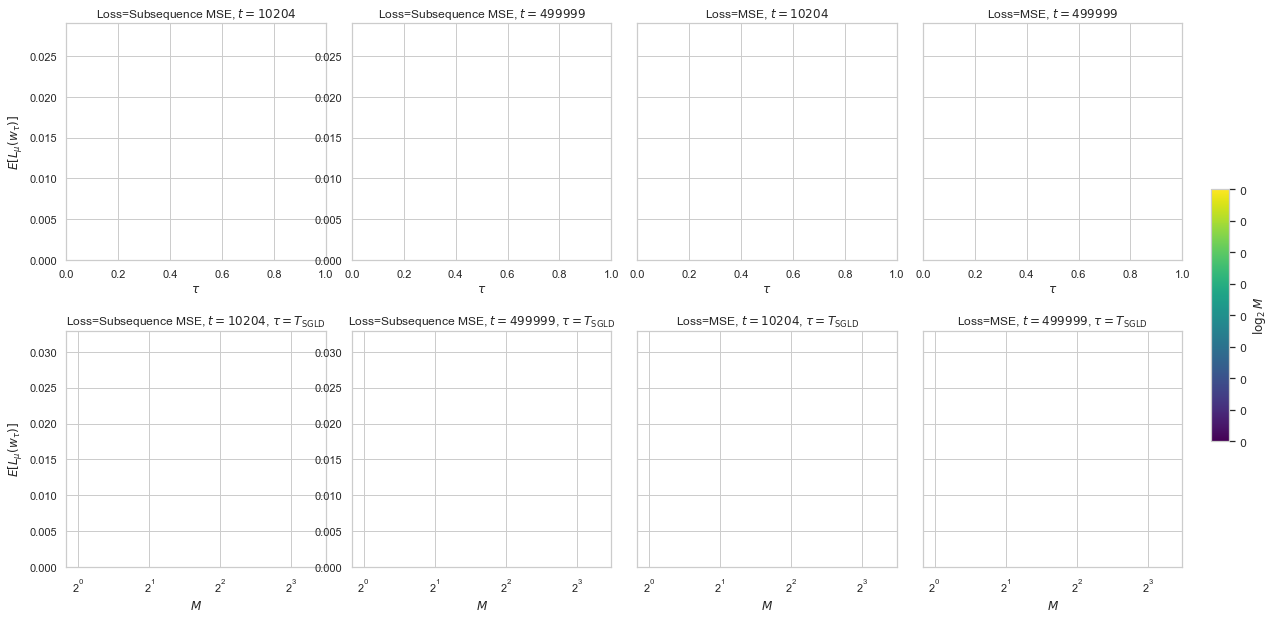

In [ ]:
num_cols = len(loss_fns) * len(focus_steps)
fig, axes = plt.subplots(2, num_cols, figsize=(5*num_cols, 10))

fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust this value as needed

max_loss_over_time = eval_loss_fn_df['loss/mean'].max() 
max_loss_at_end = eval_loss_fn_df[eval_loss_fn_df['_step'] == eval_loss_fn_df['_step'].max()]['loss/mean'].max() 

for i, loss_fn in enumerate(loss_fns):
    for j, step in enumerate(focus_steps):
        ax1, ax2 = axes[0, len(focus_steps) * i + j], axes[1, len(focus_steps) * i + j]

        _df = eval_loss_fn_df.loc[(eval_loss_fn_df['sampler_config/eval_loss_fn'] == loss_fn) & (eval_loss_fn_df['_step'] == step)]

        sns.lineplot(data=_df, x="_step", y="loss/mean", hue="log_num_tasks", palette="viridis", ax=ax1, alpha=0.5)


        loss_fn_pretty = loss_fn.replace("subsequence-mse", "Subsequence MSE").replace("mse", "MSE")
        title = f"Loss={loss_fn_pretty}, $t = {step}$"

        ax1.set_title(title)
        ax1.set_xlabel(r"$\tau$")
        ax1.legend().remove()
        ax1.set_ylim(0, max_loss_over_time * 1.1)

        _final_df = _df.loc[_df['_step'] == _df['_step'].max()]

        ax2.plot(_final_df['task_config/num_tasks'], _final_df['loss/mean'], alpha=1)
        ax2.fill_between(_final_df["task_config/num_tasks"], _final_df["loss/mean"] - _final_df["loss/std"], _final_df["loss/mean"] + _final_df["loss/std"], alpha=0.5)

        ax2.set_title(fr"{title}, $\tau = T_\mathrm{{SGLD}}$")
        ax2.set_xlabel(r"$M$")
        ax2.set_xscale('log', base=2)

        ax2.set_ylim(0, max_loss_at_end * 1.25)

        if i > 0:
            ax1.set_yticklabels([])
            ax1.set_ylabel("")
            ax2.set_yticklabels([])
            ax2.set_ylabel("")

axes[0, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")
axes[1, 0].set_ylabel(r"$E[L_\mu(w_\tau)]$")

# Add a colorbar for the hues on the left side of the top row
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=_df["log_num_tasks"].min(), vmax=_df["log_num_tasks"].max()))
sm._A = []  # Fake up the array of the scalar mappable
cb_ax = fig.add_axes([0.92, 0.3, 0.0125, 0.35])  # Adjust these values as needed for positioning and size
cbar = fig.colorbar(sm, cax=cb_ax)
cbar.set_ticklabels([f"${{{int(tick)}}}$" for tick in cbar.get_ticks()])
cbar.set_label('$\log_2 M$')  # Update this label as needed

fig.set_facecolor('white')

## Temperature, Learning Rate, and Localization Strength

In [43]:
FORCE_REEVAL = True

EVAL_EPS_TEMP_GAMMA_SWEEP_NAME = "eps-temp-gamma"
EVAL_EPS_TEMP_GAMMA_SWEEP_ID = "4njfkm0y"

if not os.path.exists(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME) or FORCE_REEVAL:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_eps_temp_gamma_sweep = api.sweep(f"devinterp/icl-llc/{EVAL_EPS_TEMP_GAMMA_SWEEP_ID}")
        eval_eps_temp_gamma_runs = list(filter_objs([r for r in eval_eps_temp_gamma_sweep.runs], config=filters))
        eval_eps_temp_gamma_df = wandb_runs_to_df(eval_eps_temp_gamma_runs)
    
    eval_eps_temp_gamma_df.to_pickle(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME)

else:
    eval_eps_temp_gamma_df = pd.read_pickle(ANALYSIS / EVAL_EPS_TEMP_GAMMA_SWEEP_NAME)

columns_to_convert = ['loss/mean', 'loss/std', 'llc/mean', 'llc/std', 'wbic/mean', 'wbic/std']  # Replace with your actual column names

for col in columns_to_convert:
    eval_eps_temp_gamma_df[col] = pd.to_numeric(eval_eps_temp_gamma_df[col], errors='coerce')

eval_eps_temp_gamma_df.reset_index(inplace=True)
eval_eps_temp_gamma_df['log_num_tasks'] = np.log2(eval_eps_temp_gamma_df['task_config/num_tasks'])
eval_eps_temp_gamma_df

Converting runs to dfs: 100%|██████████| 47/47 [00:37<00:00,  1.26it/s]


,index,_step,llc/mean,wbic/mean,_runtime,llc/std,loss/mean,loss/std,wbic/std,_timestamp,...,sampler_config/gradient_scale,sampler_config/eval_batch_size,sampler_config/grad_batch_size,sampler_config/sampling_method,sampler_config/eval_dataset_size,sampler_config/grad_batch_origin,sampler_config/localization_scale,plotting_config/include_loss_trace,plotting_config/include_weights_pca,log_num_tasks
0,0,10,0.000005,2451.663818,7288.249176,0.000004,0.002338,0.000002,2.345208,1.702755e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00010,True,False,1.0
1,1,20,0.000010,2454.215576,7291.404121,0.000009,0.002341,0.000004,4.636809,1.702755e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00010,True,False,1.0
2,2,30,0.000015,2456.819580,7294.386644,0.000014,0.002343,0.000007,7.449832,1.702755e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00010,True,False,1.0
3,3,40,0.000019,2459.101562,7297.537476,0.000020,0.002345,0.000010,10.464225,1.702755e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00010,True,False,1.0
4,4,50,0.000024,2461.392334,7300.567605,0.000026,0.002347,0.000013,13.546217,1.702755e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00010,True,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,95,960,0.003972,3096.436035,7638.885236,0.003604,0.002953,0.001802,1889.455444,1.702343e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00001,True,False,0.0
4696,96,970,0.004002,3112.206543,7641.916331,0.003628,0.002968,0.001814,1902.374268,1.702343e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00001,True,False,0.0
4697,97,980,0.004031,3127.741943,7645.102896,0.003651,0.002983,0.001826,1914.198242,1.702343e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00001,True,False,0.0
4698,98,990,0.004063,3144.101318,7648.143168,0.003682,0.002998,0.001841,1930.642578,1.702343e+09,...,0.00001,8192,1024,sgld,1048576,eval-dataset,0.00001,True,False,0.0


In [29]:
eval_eps_temp_gamma_df.columns

Index(['index', 'num_training_samples', 'batch_size', 'run_name', 'num_steps',
       'optimizer_config/optimizer_type', 'optimizer_config/lr',
       'optimizer_config/weight_decay', 'optimizer_config/momentum',
       'optimizer_config/betas', 'optimizer_config/noise_level',
       'optimizer_config/elasticity', 'optimizer_config/temperature',
       'optimizer_config/num_samples', 'scheduler_config/scheduler_type',
       'scheduler_config/step_size', 'scheduler_config/gamma',
       'scheduler_config/T_max', 'scheduler_config/eta_min',
       'scheduler_config/last_epoch', 'scheduler_config/milestones',
       'scheduler_config/lr_lambda', 'scheduler_config/max_lr',
       'scheduler_config/total_steps', 'scheduler_config/anneal_strategy',
       'scheduler_config/div_factor', 'scheduler_config/final_div_factor',
       'scheduler_config/pct_start', 'scheduler_config/cycle_momentum',
       'device', 'criterion', 'eval_batch_size', 'task_config/task_size',
       'task_config/max_e

In [44]:
eval_eps_temp_gamma_df["epsilon"] = eval_eps_temp_gamma_df["sampler_config/noise_scale"]
eval_eps_temp_gamma_df["beta"] = eval_eps_temp_gamma_df["sampler_config/gradient_scale"] * 2 / (eval_eps_temp_gamma_df["sampler_config/noise_scale"] *eval_eps_temp_gamma_df["task_config/num_tasks"])
eval_eps_temp_gamma_df["gamma"] = eval_eps_temp_gamma_df["sampler_config/localization_scale"] * 2 / eval_eps_temp_gamma_df["sampler_config/noise_scale"]

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


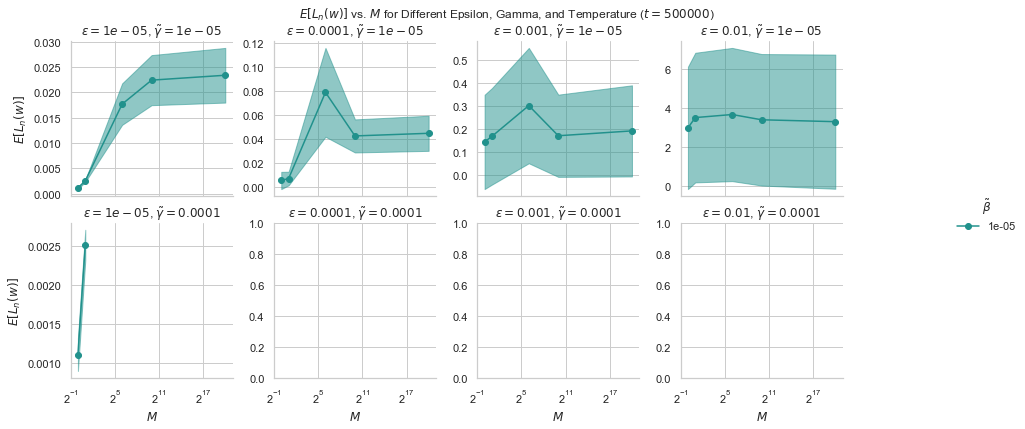

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


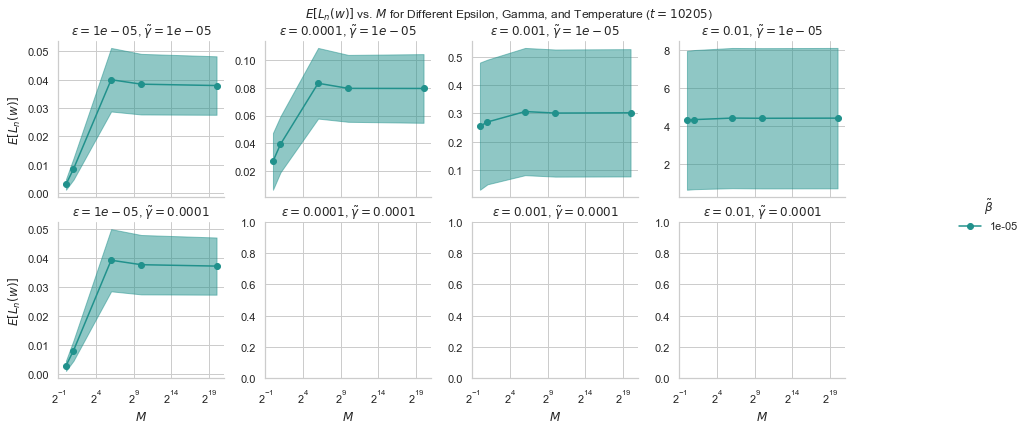

In [45]:
# Assuming eval_dataset_size_df is your DataFrame

for training_step in eval_eps_temp_gamma_df['step'].unique():
    step_df = eval_eps_temp_gamma_df[eval_eps_temp_gamma_df['step'] == training_step]

    # Step 1: Filter Data
    max_draw_df = step_df[step_df['_step'] == step_df['_step'].max()].sort_values(by='task_config/num_tasks')

    # Step 2: Create FacetGrid
    # Replace 'epsilon', 'gamma', 'temperature' with your actual column names
    g = sns.FacetGrid(data=max_draw_df, col='sampler_config/noise_scale', row='sampler_config/localization_scale', hue='sampler_config/gradient_scale', palette='viridis', sharey=False)

    def plot_cell(x, y, data=None, **kwargs):
        plt.xscale('log', base=2)
        plt.plot(data[x], data[y], 'o-', alpha=1, **kwargs)
        plt.fill_between(data[x], data[y] - data['loss/std'], data[y] + data['loss/std'], alpha=0.5, color=kwargs['color'])


    # Step 3: Plot the Data
    g = g.map_dataframe(plot_cell, 'task_config/num_tasks', 'loss/mean').add_legend()

    # Adjust layout and aesthetics as needed
    g.set_axis_labels('$M$', '$E[L_n(w)]$')
    g.set_titles(r'$\varepsilon={col_name}$, $\tilde\gamma={row_name}$')
    g.legend.set_title(r'$\tilde\beta$')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(fr'$E[L_n(w)]$ vs. $M$ for Different Epsilon, Gamma, and Temperature ($t={training_step+1}$)')

    # Show the plot
    plt.show()

# LLCs over time

In [ ]:
from devinfra.utils.iterables import flatten_dict



Converting runs to dfs:   0%|          | 0/21 [00:00<?, ?it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
Converting runs to dfs:   5%|▍         | 1/21 [00:00<00:13,  1.44it/s]/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(
/Users/Jesse/Projects/icl/.venv/lib/pyth

In [ ]:
pp(list(df.columns))

df

['llc-chain/21',
 'llc-chain/24',
 'llc-chain/7',
 'llc-chain/4',
 'llc-chain/6',
 'llc-chain/20',
 'llc-chain/10',
 'llc-chain/0',
 '_timestamp',
 '_step',
 'llc-chain/11',
 'llc/mean',
 'llc-chain/2',
 'llc-chain/19',
 'llc-chain/17',
 'llc/std',
 'llc-chain/12',
 'llc-chain/9',
 'llc-chain/18',
 'llc-chain/22',
 'llc-chain/3',
 '_runtime',
 'llc-chain/15',
 'llc-chain/13',
 'llc-chain/8',
 'llc-chain/14',
 'llc-chain/5',
 'llc-chain/16',
 'llc-chain/23',
 'llc-chain/1',
 'num_training_samples',
 'batch_size',
 'run_name',
 'num_steps',
 'optimizer_config/optimizer_type',
 'optimizer_config/lr',
 'optimizer_config/weight_decay',
 'optimizer_config/momentum',
 'optimizer_config/betas',
 'optimizer_config/noise_level',
 'optimizer_config/elasticity',
 'optimizer_config/temperature',
 'optimizer_config/num_samples',
 'scheduler_config/scheduler_type',
 'scheduler_config/step_size',
 'scheduler_config/gamma',
 'scheduler_config/T_max',
 'scheduler_config/eta_min',
 'scheduler_config/last

,llc-chain/21,llc-chain/24,llc-chain/7,llc-chain/4,llc-chain/6,llc-chain/20,llc-chain/10,llc-chain/0,_timestamp,_step,...,task_config/noise_variance,task_config/embed_size,task_config/mlp_size,task_config/num_heads,task_config/num_layers,task_config/model_seed,task_config/pretrain_seed,task_config/true_seed,task_config/sampling_seed,task_config/layer_norm
0,-31.492245,-34.640392,-37.571781,-29.759884,-34.418633,-33.259899,-39.27005,-27.284689,1.701769e+09,0,...,0.125,64,64,4,2,0,1,2,3,True
1,-37.149822,-31.687656,-36.097107,-34.656593,-37.521626,-36.160576,-32.603851,-32.284039,1.701770e+09,1,...,0.125,64,64,4,2,0,1,2,3,True
2,-33.165081,-36.720608,-35.567787,-43.45013,-41.736015,-38.18063,-40.780159,-36.970047,1.701770e+09,2,...,0.125,64,64,4,2,0,1,2,3,True
3,-32.224651,-31.908781,-38.273193,-34.63229,-39.1908,-31.796915,-33.310265,-45.639111,1.701771e+09,3,...,0.125,64,64,4,2,0,1,2,3,True
4,-37.2402,-40.164619,-33.410297,-41.476849,-38.946991,-32.499805,-44.019531,-29.738609,1.701772e+09,4,...,0.125,64,64,4,2,0,1,2,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,22.153051,13.162414,10.061708,5.37724,14.821695,12.0565,15.54309,16.07786,1.701473e+09,459183,...,0.125,64,64,4,2,0,1,2,3,True
92,16.378391,9.404738,11.65611,16.117937,19.421547,15.99394,16.026758,13.233388,1.701474e+09,469387,...,0.125,64,64,4,2,0,1,2,3,True
93,13.902676,12.52443,18.67099,12.419909,3.605349,12.773421,15.656064,18.471336,1.701475e+09,479591,...,0.125,64,64,4,2,0,1,2,3,True
94,15.490371,17.433939,4.917962,11.864624,19.78948,10.031211,6.908941,10.63745,1.701475e+09,489795,...,0.125,64,64,4,2,0,1,2,3,True


In [ ]:
llc_chain_columns = [f'llc-chain/{i}' for i in range(25)]
df[llc_chain_columns] = df[llc_chain_columns].replace("NaN", np.nan)


# Calculate the average of non-NaN values in llc-chain columns
# and the fraction of NaN values
llc_chain_values = df[llc_chain_columns]
mean_llc_chain = llc_chain_values.mean(axis=1, skipna=True)
frac_nan = llc_chain_values.isna().mean(axis=1)

df["llc/mean-fixed"] = mean_llc_chain
df["llc/frac-nan"] = frac_nan
df["log_num_tasks"] = np.log(df["task_config/num_tasks"])

mean_llc_chain, frac_nan

(0    -35.240626
 1    -36.057135
 2    -37.265739
 3    -35.599871
 4    -37.586922
         ...    
 91    11.272044
 92    13.656166
 93    13.961580
 94    13.416571
 95    12.224514
 Length: 2016, dtype: float64,
 0     0.0
 1     0.0
 2     0.0
 3     0.0
 4     0.0
      ... 
 91    0.0
 92    0.0
 93    0.0
 94    0.0
 95    0.0
 Length: 2016, dtype: float64)

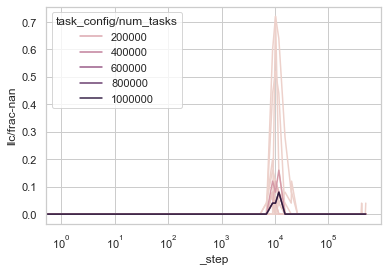

In [ ]:
sns.lineplot(data=df, x="_step", y="llc/frac-nan", hue="task_config/num_tasks")
plt.xscale("log")

In [ ]:
from matplotlib import patches


TRANSITIONS = [
    (100, 800, 'A1'),
    (800, 10_000, 'A2'),
    (10_000, 28_000, 'B1'),
    (28_000, 280_000, 'B2'),
]

INIT_X = TRANSITIONS[0][0]
FINAL_X = TRANSITIONS[-1][1]

def plot_transitions(axes, **kwargs):
    from icl.figures.colors import plot_transitions as _plot_transitions
    return _plot_transitions(axes, TRANSITIONS, **kwargs)

In [ ]:
steps = checkpointers[0].file_ids
steps

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 11,
 14,
 19,
 24,
 32,
 42,
 55,
 72,
 94,
 124,
 162,
 211,
 276,
 362,
 473,
 618,
 808,
 1056,
 1381,
 1805,
 2359,
 3084,
 4031,
 5269,
 6887,
 9003,
 10204,
 11767,
 15381,
 20104,
 20408,
 26279,
 30612,
 34349,
 40816,
 44897,
 51020,
 58684,
 61224,
 71428,
 76706,
 81632,
 91836,
 100262,
 102040,
 112244,
 122448,
 131051,
 132653,
 142857,
 153061,
 163265,
 171296,
 173469,
 183673,
 193877,
 204081,
 214285,
 223899,
 224489,
 234693,
 244897,
 255102,
 265306,
 275510,
 285714,
 292657,
 295918,
 306122,
 316326,
 326530,
 336734,
 346938,
 357142,
 367346,
 377551,
 382529,
 387755,
 397959,
 408163,
 418367,
 428571,
 438775,
 448979,
 459183,
 469387,
 479591,
 489795,
 499999]

In [ ]:
from collections import defaultdict
from icl.evals import ICLEvaluator
from icl.experiments.activations_analysis import iter_models
from icl.train import Run

evals = []
functional_metrics = []
gradient_norms = []

B = 8192
K = 8
D = 4
OOD_MULTIPLIER = 3

def eval_loss(yhats, ys):
    return ((yhats - ys) ** 2).mean(dim=0)[:, 0]

def apply_transformations(ws, xs):
    return xs @ ws.view(B, D, 1)

for log2_M, config in tqdm(enumerate(configs)):
    run = Run(config)
    run.evaluator = ICLEvaluator(
        pretrain_dist=run.pretrain_dist,
        true_dist=run.true_dist,
        max_examples=config.task_config.max_examples,
        eval_batch_size=8192,
        seed=config.task_config.true_seed,
    )
    pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
        DEVICE
    )
    noise_std = pretrain_dist_noiseless.std
    pretrain_dist_noiseless.std = 0.

    ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D 
    wpriors = pretrain_dist_noiseless.task_distribution.tasks.mean(dim=0) # -> D
    wpriors = wpriors.repeat(B, 1) # -> B D

    xs = torch.normal(
        mean=0.,
        std=1.,
        size=(B, K, D,),
        device=DEVICE
    )
    ood_xs = OOD_MULTIPLIER * xs

    errors = torch.normal(
        mean=0.,
        std=noise_std,
        size=(B, K, 1,),
        device=DEVICE,
    )

    ys_without_noise = apply_transformations(ws, xs)
    ood_ys_without_noise= OOD_MULTIPLIER * ys_without_noise

    ys = ys_without_noise + errors
    ood_ys = ood_ys_without_noise + errors

    yhats_prior = apply_transformations(wpriors, xs)
    yhats_zero = torch.zeros_like(ys)
    # ood_yhats_prior = apply_transformations(wpriors, ood_xs)
    
    for step, model in zip(steps, iter_models(run.model, run.checkpointer)):
        yhats = model(xs, ys)
        ood_yhats = model(xs, ood_ys)
        # yhats_without_noise = model(xs, ys_without_noise)

        losses = eval_loss(yhats, ys)
        # losses_without_noise = eval_loss(yhats_without_noise, ys_without_noise)
        losses_prior = eval_loss(yhats, yhats_prior)
        losses_zero = eval_loss(yhats, yhats_zero)

        ood_losses = eval_loss(ood_yhats, ood_ys)
        # ood_losses_midpoint = eval_loss(ood_yhats, ood_yhats_prior)
        # ood_losses_without_noise = eval_loss(yhats, ood_ys_without_noise)

        loss = losses.mean()
        loss.backward()

        for n, p in model.named_parameters():
            if p.grad is None:
                continue

            grad_sq_mean = (p.grad ** 2).mean().item()
            grad_sq_std = (p.grad ** 2).std().item()

            gradient_norms.append({
                "m": log2_M,
                "M": 2 ** log2_M,    
                "step": step,
                "layer": n,
                "grad/norm": grad_sq_mean ** 0.5,
                "grad_sq/mean": grad_sq_mean,
                "grad_sq/std": grad_sq_std,
                "numel": p.numel(),
                "loss": loss.item(),
            })          

            p.grad = None 

        for token in range(8):
            functional_metrics.append({
                "m": log2_M,
                "M": 2 ** log2_M,
                "step": step,
                "loss": losses[token].item(),
                "ood_loss": ood_losses[token].item(),
                # "loss_without_noise": losses_without_noise[i],
                # "ood_loss_without_noise": ood_losses_without_noise[i],
                "loss_prior": losses_prior[token].item(),
                "loss_zero": losses_zero[token].item(),
                # "ood_loss_midpoint": ood_losses_midpoint[i],
                "token": token
            })

        evals.append({
            "m": log2_M,
            "M": 2 ** log2_M,
            "step": step,
            "weight_norm": (sum([(p ** 2).sum() for p in model.parameters()]) ** 0.5).item(),
            **run.evaluator(model),
        })


evals = pd.DataFrame(evals)
evals.to_csv(ANALYSIS / "small-model-evals.csv", index=False)
functional_metrics = pd.DataFrame(functional_metrics)
functional_metrics.to_csv(ANALYSIS / "small-model-functional-metrics.csv", index=False)
gradient_norms = pd.DataFrame(gradient_norms)
gradient_norms.to_csv(ANALYSIS / "small-model-gradient-norms.csv", index=False)

0it [00:08, ?it/s]


KeyboardInterrupt: 

In [ ]:
evals = pd.read_csv(ANALYSIS / "small-model-evals.csv")
functional_metrics = pd.read_csv(ANALYSIS / "small-model-functional-metrics.csv")
gradient_norms = pd.read_csv(ANALYSIS / "small-model-gradient-norms.csv")

In [ ]:
evals.columns

In [ ]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

In [ ]:
for log2_M in range(20):
    # Filter the DataFrame and compute the derivatives
    mse_values = evals.loc[evals.m == log2_M, "pretrain/mse"].values
    llc_values = df.loc[df["task_config/num_tasks"] == int(2 ** log2_M), "llc/mean-fixed"].values
    weightnorm_values = evals.loc[evals.m == log2_M, "weight_norm"].values
    
    # Compute the derivatives using your d_dlogt function
    dloss_dlogt_values = d_dlogt(steps, mse_values)
    dllc_dlogt_values = d_dlogt(steps, llc_values)
    dweightnorm_dlogt_values = d_dlogt(steps, weightnorm_values)

    # Assign the computed derivatives back to the original DataFrame
    evals.loc[evals.m == log2_M, "dloss_dlogt"] = dloss_dlogt_values
    evals.loc[evals.m == log2_M, "dllc_dlogt"] = dllc_dlogt_values
    evals.loc[evals.m == log2_M, "dweightnorm_dlogt"] = dweightnorm_dlogt_values


In [ ]:
evals.columns

[(0.280894, 0.078907, 0.402329), (0.28229, 0.145912, 0.46151), (0.270595, 0.214069, 0.507052), (0.250425, 0.27429, 0.533103), (0.223925, 0.334994, 0.548053), (0.19943, 0.387607, 0.554642), (0.175841, 0.44129, 0.557685), (0.15627, 0.489624, 0.557936), (0.136408, 0.541173, 0.554483), (0.121831, 0.589055, 0.545623), (0.12478, 0.640461, 0.527068), (0.162016, 0.687316, 0.499129), (0.239374, 0.735588, 0.455688), (0.335885, 0.777018, 0.402049), (0.458674, 0.816363, 0.329727), (0.585678, 0.846661, 0.249897)]


<ipython-input-46-5cb07c9b31ef>:20: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:29: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:39: UserWarning: The palette list has more values (16) than needed (13), which may not be intended.
  sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks > 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-46-5cb07c9b31ef>:48: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", pale

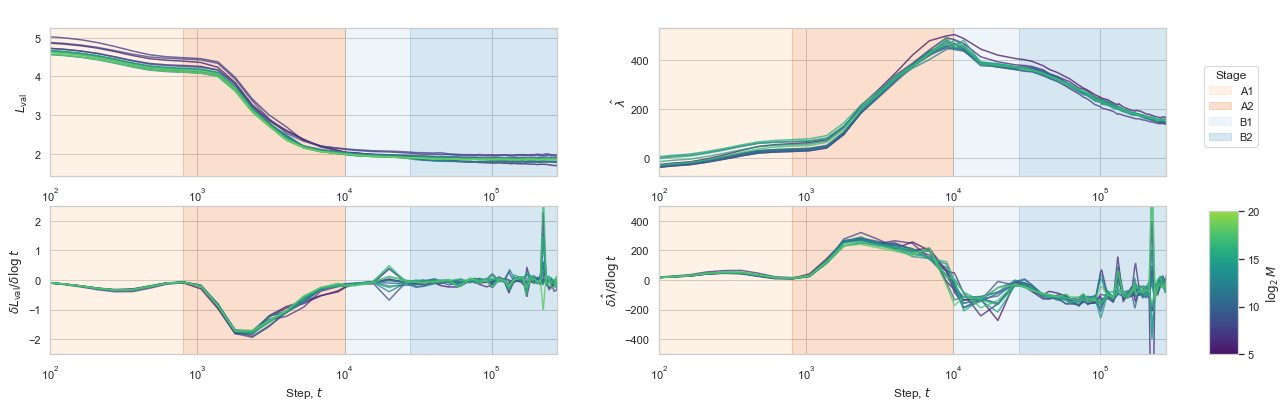

In [ ]:
from matplotlib import colors, lines, patches

def get_reduced_viridis_palette(num_colors, ratio=3 / 3.5):
    return sns.color_palette("viridis", int(num_colors // ratio))[:num_colors]

LINE_PALETTE = get_reduced_viridis_palette(21-5)
# num_palette_steps = int((21 * 3.75) // 3)
# LINE_PALETTE = [sns.color_palette("coolwarm", num_palette_steps)[i] for i in [*range(10), *range(num_palette_steps - 10, num_palette_steps)]]

print(LINE_PALETTE)
# "viridis"
ALPHA=0.75

fig, axes = plt.subplots(2, 2, figsize=(20, 6))

ax = axes[0, 0]

filtered_evals = evals.loc[(evals.step != 20408) & (evals['m'] > 5)]

sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

ax = axes[1, 0]

sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta L_\mathrm{val}/\delta \log t$")
ax.legend().remove()
ax.set_ylim(-2.5, 2.5)

ax = axes[0, 1]

sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks > 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\hat\lambda$")
ax.legend().remove()

ax = axes[1, 1]

sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \hat\lambda/\delta \log t$")
ax.set_ylim(-500, 500)
ax.legend().remove()

# ax = axes[0, 2]

# sns.lineplot(data=filtered_evals, x="step", y="weight_norm", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$|w_t|$")
# ax.legend().remove()

# ax.set_ylim(20, 800)

# ax = axes[1, 2]

# sns.lineplot(data=filtered_evals, x="step", y="dweightnorm_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$\delta|w_t|/\delta\log t$")
# ax.legend().remove()

_patches = plot_transitions(axes)


handles, labels = ax.get_legend_handles_labels()

# Create custom handles
# handles = [lines.Line2D([], [], color=custom_colors[i], marker='o', linestyle='', label=custom_labels[i]) for i in range(len(custom_labels))]

# Add the custom handles to the existing ones
# handles.extend(custom_handles)

# Now, you can create the legend with the updated handles and custom labels
# axes[0, 2].legend(handles=handles, title="$\log_2 M$", loc='center right', bbox_to_anchor=(0.9, .5))

# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
# plt.tight_layout()

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.33])  # Adjust as necessary for position and size
custom_cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0+5, vmax=20), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions =  [5, 10, 15, 20]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


stages_legend_ax = fig.add_axes([0.945, 0.68, 0.02, 0.25])  # Adjust as necessary for position and size
stages_legend_ax.axis('off')
stages_legend_ax.legend(handles=_patches, title="Stage", loc='upper center', bbox_to_anchor=(0, .5))

fig.set_facecolor('white')


[(0.267968, 0.223549, 0.512008), (0.190631, 0.407061, 0.556089), (0.127568, 0.566949, 0.550556), (0.20803, 0.718701, 0.472873), (0.565498, 0.84243, 0.262877)]


<ipython-input-47-bb545bb90122>:20: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:29: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:39: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks <= 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
<ipython-input-47-bb545bb90122>:48: UserWarning: 
The palette list has fewer values (5) than needed (6) and will 

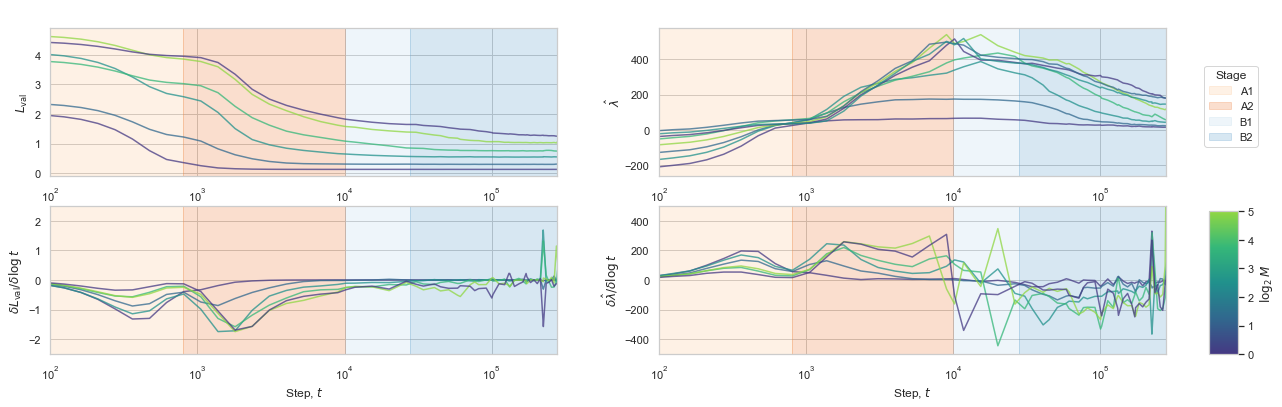

In [ ]:
from matplotlib import colors, lines, patches

def get_reduced_viridis_palette(num_colors, ratio=3 / 3.5):
    return sns.color_palette("viridis", int(num_colors // ratio))[:num_colors]

LINE_PALETTE = get_reduced_viridis_palette(5)
# num_palette_steps = int((21 * 3.75) // 3)
# LINE_PALETTE = [sns.color_palette("coolwarm", num_palette_steps)[i] for i in [*range(10), *range(num_palette_steps - 10, num_palette_steps)]]

print(LINE_PALETTE)
# "viridis"
ALPHA=0.75

fig, axes = plt.subplots(2, 2, figsize=(20, 6))

ax = axes[0, 0]

filtered_evals = evals.loc[(evals.step != 20408) & (evals['m'] <= 5)]

sns.lineplot(data=filtered_evals, x="step", y="pretrain/mse", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

ax = axes[1, 0]

sns.lineplot(data=filtered_evals, x="step", y="dloss_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta L_\mathrm{val}/\delta \log t$")
ax.legend().remove()
ax.set_ylim(-2.5, 2.5)

ax = axes[0, 1]

sns.lineplot(data=df.loc[(df._step != 20408) & (df.log_num_tasks <= 5)], x="_step", y="llc/mean-fixed", hue="log_num_tasks", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\hat\lambda$")
ax.legend().remove()

ax = axes[1, 1]

sns.lineplot(data=filtered_evals, x="step", y="dllc_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_xscale("log")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \hat\lambda/\delta \log t$")
ax.set_ylim(-500, 500)
ax.legend().remove()

# ax = axes[0, 2]

# sns.lineplot(data=filtered_evals, x="step", y="weight_norm", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$|w_t|$")
# ax.legend().remove()

# ax.set_ylim(20, 800)

# ax = axes[1, 2]

# sns.lineplot(data=filtered_evals, x="step", y="dweightnorm_dlogt", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
# ax.set_xscale("log")
# ax.set_xlim(INIT_X, FINAL_X)
# ax.set_xlabel("Step, $t$")
# ax.set_ylabel("$\delta|w_t|/\delta\log t$")
# ax.legend().remove()

_patches = plot_transitions(axes)


handles, labels = ax.get_legend_handles_labels()

# Create custom handles
# handles = [lines.Line2D([], [], color=custom_colors[i], marker='o', linestyle='', label=custom_labels[i]) for i in range(len(custom_labels))]

# Add the custom handles to the existing ones
# handles.extend(custom_handles)

# Now, you can create the legend with the updated handles and custom labels
# axes[0, 2].legend(handles=handles, title="$\log_2 M$", loc='center right', bbox_to_anchor=(0.9, .5))

# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
# plt.tight_layout()

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.33])  # Adjust as necessary for position and size
custom_cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=0, vmax=5), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions =  [0, 1, 2, 3, 4, 5]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


stages_legend_ax = fig.add_axes([0.945, 0.68, 0.02, 0.25])  # Adjust as necessary for position and size
stages_legend_ax.axis('off')
stages_legend_ax.legend(handles=_patches, title="Stage", loc='upper center', bbox_to_anchor=(0, .5))

fig.set_facecolor('white')

# Functional

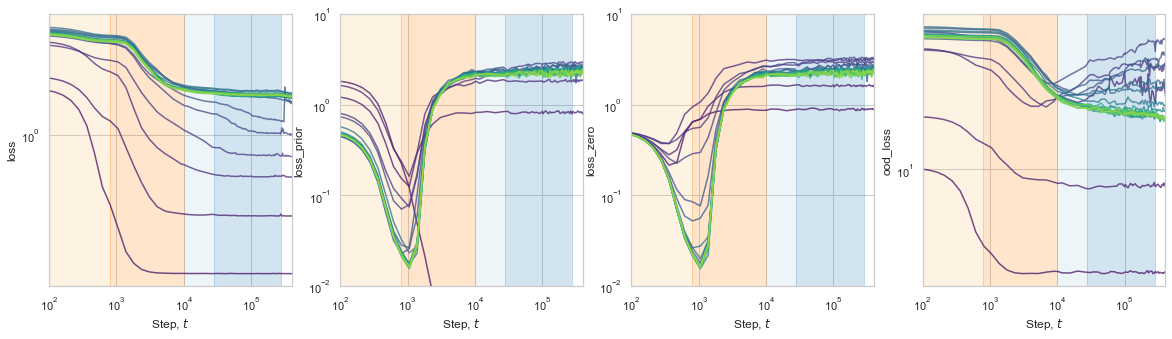

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
functional_metrics_averages = functional_metrics.groupby(["m", "step"]).mean().reset_index()

ax = axes[0]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_prior", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[2]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_zero", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[3]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="ood_loss", hue="m", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes) #, alpha=0.8)

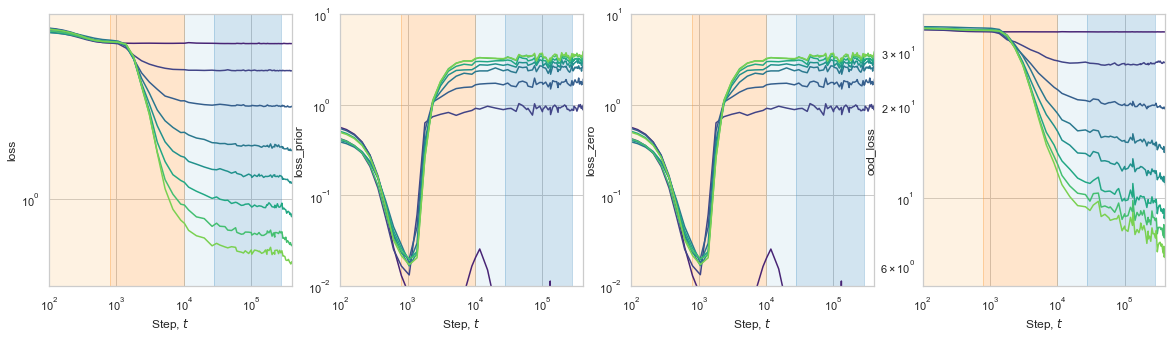

In [ ]:
LINE_PALETTE = get_reduced_viridis_palette(8)
ALPHA = 1

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
functional_metrics_m20 = functional_metrics.loc[functional_metrics.m == 20]

ax = axes[0]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss_prior", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[2]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="loss_zero", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
ax.set_ylim(0.01, 10)

ax = axes[3]
sns.lineplot(data=functional_metrics_m20.loc[functional_metrics_m20.step != 20408], x="step", y="ood_loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes) #, alpha=0.8)

<ipython-input-164-19bef9351227>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


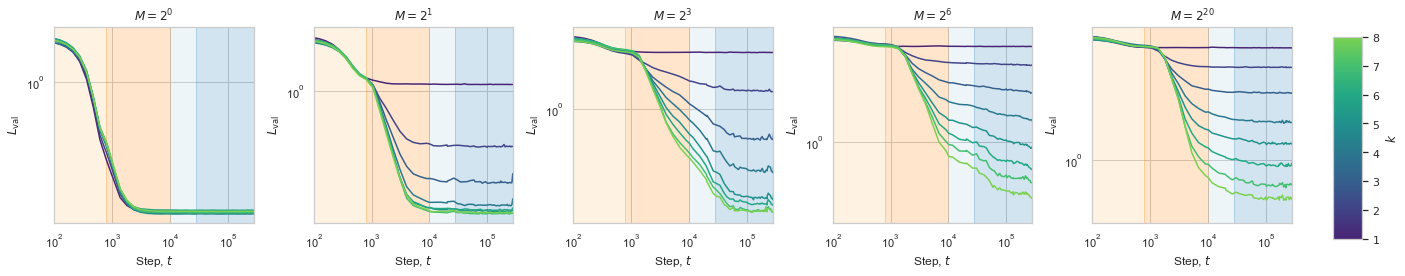

In [ ]:
from matplotlib import colors as mcolors

# LINE_PALETTE="viridis"
# ALPHA=1

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for token, log2_M in enumerate([0, 1, 3, 6, 20]):
    # Average across token colum
    ax = axes[token]
    functional_metrics_specific = functional_metrics.loc[functional_metrics.m == log2_M]
    sns.lineplot(data=functional_metrics_specific, x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)
    ax.set_title(f"$M = 2^{{{log2_M}}}$")


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(INIT_X, FINAL_X)
    ax.set_xlabel("Step, $t$")
    ax.set_ylabel("$L_\mathrm{val}$")
    ax.legend().remove()

add_milestones(axes, alpha=0.2) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<ipython-input-177-48ccdd0f7979>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make

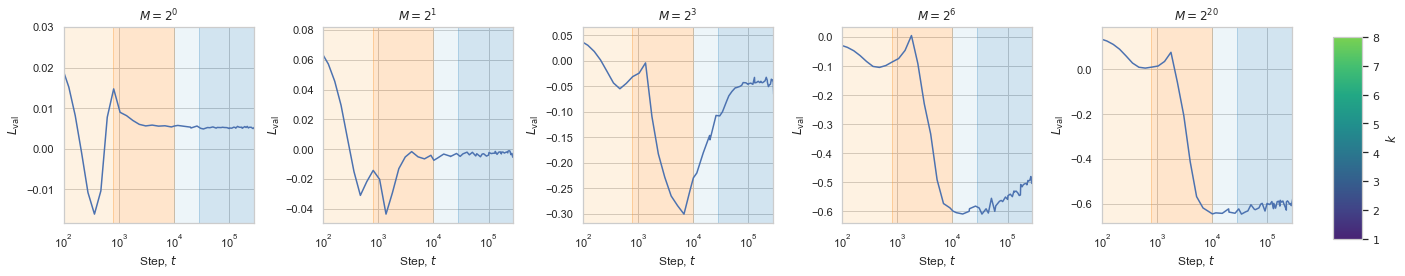

In [ ]:
from matplotlib import colors as mcolors

# LINE_PALETTE="viridis"
# ALPHA=1

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for token, log2_M in enumerate([0, 1, 3, 6, 20]):
    # Average across token colum
    ax = axes[token]
    functional_metrics_specific = functional_metrics.loc[functional_metrics.m == log2_M]

    icl_score = functional_metrics_specific.loc[functional_metrics_specific.token == 7, "loss"].values - functional_metrics_specific.loc[functional_metrics_specific.token == 4, "loss"].values
    sns.lineplot(x=steps, y=icl_score, alpha=ALPHA, ax=ax)
    ax.set_title(f"$M = 2^{{{log2_M}}}$")


for ax in axes.flatten():
    # ax.set_yscale('symlog')
    ax.set_xscale("log")
    ax.set_xlim(INIT_X, FINAL_X)
    ax.set_xlabel("Step, $t$")
    ax.set_ylabel("$L_\mathrm{val}$")
    ax.legend().remove()

add_milestones(axes, alpha=0.2) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


In [ ]:
wpriors_over_m = []
wprior_norms_over_m = []

for log2_M, config in tqdm(enumerate(configs)):
    run = Run(config)
    run.evaluator = ICLEvaluator(
        pretrain_dist=run.pretrain_dist,
        true_dist=run.true_dist,
        max_examples=config.task_config.max_examples,
        eval_batch_size=8192,
        seed=config.task_config.true_seed,
    )
    pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
        DEVICE
    )
    noise_std = pretrain_dist_noiseless.std
    pretrain_dist_noiseless.std = 0.

    ws = pretrain_dist_noiseless.task_distribution.sample_tasks(B) # -> B D 
    wpriors = pretrain_dist_noiseless.task_distribution.tasks.mean(dim=0) # -> D
    wpriors_over_m.append(wpriors)
    wprior_norms_over_m.append(wpriors.norm())

In [ ]:
plt.plot(np.arange(21), [w.item() for w in wprior_norms_over_m])
plt.yscale("log")

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Average across token colum
for log2_M in range(21):
    functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_zero_norm"] = functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_zero"] / wprior_norms_over_m[log2_M].item()
    functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_prior_norm"] = functional_metrics_averages.loc[functional_metrics_averages.m == log2_M, "loss_prior"] / wprior_norms_over_m[log2_M].item()

ax = axes[0]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss", hue="m", palette="viridis", alpha=0.5, ax=ax)

ax = axes[1]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_prior_norm", hue="m", palette="viridis", alpha=0.5, ax=ax)
ax.set_ylim(0.01, 1000)

ax = axes[2]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="loss_zero_norm", hue="m", palette="viridis", alpha=0.5, ax=ax)
ax.set_ylim(0.01, 1000)

ax = axes[3]
sns.lineplot(data=functional_metrics_averages.loc[functional_metrics_averages.step != 20408], x="step", y="ood_loss", hue="m", palette="viridis", alpha=0.5, ax=ax)

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xscale("log")
    ax.set_xlim(100, 400_000)
    ax.set_xlabel("Step, $t$")
    ax.legend().remove()

add_milestones(axes)

In [ ]:
m20_batch_losses_np = [m20_batch_losses[I:I + 100] for I in range(0, len(m20_batch_losses), 100)]
m20_batch_losses_np = np.array(m20_batch_losses_np)
m20_batch_losses_np.shape

In [ ]:
m20_batch_losses_cumsum = np.cumsum(m20_batch_losses_np, axis=1)
m20_batch_losses_cumavg = m20_batch_losses_cumsum / np.arange(1, 101)

m20_batch_losses_df = pd.DataFrame([{"step": step, "loss": loss, "b": b} for step, losses in zip(steps, m20_batch_losses_cumavg) for b, loss in enumerate(losses)])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(20, 5))


ax = axes[0]
# First plot
m20_functional_metrics = functional_metrics_averages.loc[functional_metrics_averages.m == 20]
sns.lineplot(data=m20_batch_losses_df, x="step", y="loss", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax, legend=None)
sns.lineplot(data=m20_functional_metrics, x="step", y="loss", color=sns.color_palette('bright')[1], alpha=1, ax=ax, linewidth=2, label="$L_\mathrm{val}$")
ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\mathrm{Loss}$")
ax.set_xlim(INIT_X, FINAL_X)
ax.legend(loc="lower left")

ax=axes[1]

for b in range(100):
    m20_batch_loss_slope = d_dlogt(steps, m20_batch_losses_cumavg[:, b])
    m20_batch_losses_df.loc[m20_batch_losses_df.b == b, "slope"] = m20_batch_loss_slope

m20_val_loss_slopes = d_dlogt(steps, m20_functional_metrics.loss.values)
sns.lineplot(data=m20_batch_losses_df, x="step", y="slope", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax, legend=None)
sns.lineplot(data=m20_functional_metrics, x="step", y=m20_val_loss_slopes, color=sns.color_palette('bright')[1], alpha=0.75, ax=ax, linewidth=2, label="$\delta L_\mathrm{val}/\delta \log t$")
# ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$\delta \mathrm{Loss}/\delta \log t$")
ax.set_xlim(INIT_X, FINAL_X)
ax.set_ylim(-2, 1)
ax.legend(loc="lower left")

# Create an inset for the second plot

# ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')

# # Second plot (inset)
# sns.lineplot(data=m20_batch_losses_df, x="step", y="loss", hue="b", palette=get_reduced_viridis_palette(100), alpha=0.5, ax=ax_inset, legend=None)
# sns.lineplot(data=m20_functional_metrics, x="step", y="loss", color=sns.color_palette('deep')[3], alpha=1, ax=ax_inset)
# ax_inset.set_xlim(10_000, 250_000)
# ax_inset.set_ylim(1.75, 2.25)
# ax_inset.set_xscale("log")
# ax_inset.set_yscale('log')

add_milestones(axes)

# plt.show()

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", get_reduced_viridis_palette(100))

sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=1, vmax=101), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = list(range(1, 101, 10)) + [100] # Positions for each color
tick_labels = ["1"] +  [f"${i}$" for i in range(10, 101, 10)]  # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$b$")


## Fitting

In [ ]:
def get_milestone_indices(steps, milestones):
    milestone_indices = []
    for step in steps:
        # Find the index of the milestone that the current step falls into
        index = next((i for i, milestone in enumerate(milestones) if milestone[0] <= step < milestone[1]), None)
        milestone_indices.append(index if index is not None else 'Out of defined milestones')
    return milestone_indices

milestones_of_steps = get_milestone_indices(steps, TRANSITIONS)

In [ ]:
run = Run(configs[0])
sum(p.numel() for p in run.model.parameters())

In [ ]:
from icl.baselines import dmmse_predictor, ridge_predictor
from icl.tasks import TaskDistribution, DiscreteTaskDistribution, RegressionSequenceDistribution

class DMMSE(nn.Module):
    def __init__(self, dist: RegressionSequenceDistribution, noise_variance: float, learn_prior: bool = False):
        super().__init__()

        self.prior = dist.task_distribution
        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))

        if learn_prior:
            self.tasks = nn.Parameter(self.prior.tasks)
            self.prior.tasks = self.tasks
    
    def forward(self, xs, ys):
        return dmmse_predictor(xs, ys, self.prior, self.noise_variance)


class Ridge(nn.Module):
    def __init__(self, noise_variance: float):
        super().__init__()

        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))


    def forward(self, xs, ys):
        return ridge_predictor(xs, ys, self.noise_variance)


def fit_baseline_predictor(baseline: nn.Module, model: nn.Module, dist: RegressionSequenceDistribution, num_steps: int=1000, lr: float=0.0001, device: str = "cpu", batch_size=128, num_examples=8, verbose=True):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We're fitting just a single parameter (the noise variance)

    if verbose:
        losses = []
        sigmas = []

    for step in tqdm(range(num_steps), desc="Fitting..."):
        optimizer.zero_grad()

        # Get a batch of data
        xs, ys = dist.get_batch(batch_size=batch_size, num_examples=num_examples)
        xs = xs.to(device)
        ys = ys.to(device)

        # Get the predictions of the reference model
        with torch.no_grad():
            yhats = model(xs, ys)

        # Get the predictions of the baseline
        baseline_preds = baseline(xs, ys)

        # Update the baseline to be closer to the reference model
        loss = criterion(baseline_preds, yhats)
        loss.backward()
        optimizer.step()

        if verbose:
            losses.append(loss.item())
            sigmas.append(baseline.noise_variance.item())

    if verbose:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        plt.suptitle(f"Baseline fitting {baseline.__class__.__name__} on {dist.task_distribution.__class__.__name__}")
        axes[0].plot(losses)
        axes[0].set_title("Loss")
        axes[1].plot(sigmas)
        axes[1].set_title("Noise variance")
        plt.show()

    return baseline

def eval_delta_predictor(baseline: nn.Module, model: nn.Module, xs, ys, device: str = "cpu"):
    baseline_preds = baseline(xs, ys)
    preds = model(xs, ys)

    return nn.MSELoss()(baseline_preds, preds)

In [ ]:
from devinfra.utils.iterables import flatten_dict
from icl.train import Run
import random

fit_baseline_results = []

lr = 0.01
num_steps = 2_00
LEARN_PRIOR = False

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    run.model.load_state_dict(checkpointer[-1]["model"])

    print("Evaluating", run.config.to_slug())

    batch_size = run.config.batch_size
    num_examples = run.config.task_config.max_examples
    
    noise = run.config.task_config.noise_variance

    learned_dmmse_pretrain = DMMSE(run.pretrain_dist, noise_variance=noise, learn_prior=LEARN_PRIOR)
    learned_ridge_pretrain = Ridge(noise_variance=noise)
    learned_ridge_true = Ridge(noise_variance=noise)

    init_learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)
    
    fit_baseline_predictor(learned_dmmse_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_true, run.model, run.true_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)

    learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)

    fit_baseline_results.append({
        "step": checkpointer.file_ids[-1],
        "config": run.config.to_slug(),
        "learned_dmmse_pretrain/init_delta": init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/init_delta": init_learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/init_delta": init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta": learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta": learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/delta": learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta_delta": learned_dmmse_pretrain_delta.item() - init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta_delta": learned_ridge_pretrain_delta.item() - init_learned_ridge_pretrain_delta.item(),        
        "learned_ridge_true/delta_delta": learned_ridge_true_delta.item() - init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/noise_variance": learned_dmmse_pretrain.noise_variance.item(),
        "learned_ridge_pretrain/noise_variance": learned_ridge_pretrain.noise_variance.item(),
        "learned_ridge_true/noise_variance": learned_ridge_true.noise_variance.item(),
        **flatten_dict(run.config.task_config.model_dump(), flatten_lists=True)
    })

    pp(fit_baseline_results[-1])



In [ ]:
baseline_fits_df = pd.DataFrame(fit_baseline_results)

# Create 2x3 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

plt.suptitle(
    "L2-H4-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000@t=499999"
)

# Define the labels for rows
row_labels = ['dmmse_pretrain', 'ridge_pretrain', 'ridge_true']

# Loop through the rows
for token, row_label in enumerate(row_labels):
    
    # First column: init_delta and delta
    ax1 = axes[token, 0]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/init_delta', ax=ax1, label=f'{row_label} init_delta')
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/delta', ax=ax1, label=f'{row_label} delta')
    ax1.set_title(f"{row_label} init_delta and delta")
    ax1.set_xlabel('num_tasks')
    ax1.set_ylabel('Value')
    
    # Second column: noise_variance
    ax2 = axes[token, 1]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/noise_variance', ax=ax2, label=f'{row_label} noise_variance')
    ax2.axhline(y=0.125, color='r', linestyle='-', label='True noise_variance')

    ax2.legend()

    ax2.set_title(f"{row_label} noise_variance")
    ax2.set_xlabel('num_tasks')
    ax2.set_ylabel('Noise Variance')

for ax in axes.flat:
    ax.set_xscale("log")

plt.tight_layout(rect=[0.1, 0.1, 1, 1])
plt.show()


## PCA

In [ ]:
def iter_enumerated_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield file_id, model

def iter_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield model

In [ ]:
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

In [ ]:
# demo = Run(configs[2])
# demo_models = iter_models(demo.model, demo.checkpointer, verbose=True)

# demo_logits_pca_3, demo_logits_reduced_3  = get_pca_activations_trace(
#     demo_models, 
#     demo.evaluator.pretrain_xs, 
#     demo.evaluator.pretrain_ys, 
#     "token_sequence_transformer",
#     num_components=3
# )['token_sequence_transformer']

# steps = demo.checkpointer.file_ids

In [ ]:
from typing import Optional

def plot_sample_evolution(steps, samples, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Main plot
    sc = ax.scatter(samples[:, 0], samples[:, 1], c=steps, cmap='viridis', s=50, alpha=0.6)

    if connect_dots:
        ax.plot(samples[:, 0], samples[:, 1], c='black', alpha=0.2)

    plt.colorbar(sc, ax=ax, label='Steps')
    
    # Label some points
    total_samples = len(samples)
    step = total_samples // num_points_to_label
    for i in range(0, total_samples, step):
        sample_step = steps[i]
        ax.text(samples[i, 0], samples[i, 1], str(sample_step), fontsize=12, ha='right', va='bottom')
        
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)


def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Component')
    ax.set_ylabel('Variance')


def plot_sample_evolution_with_inset(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    plot_sample_evolution(steps, samples, title=title, num_points_to_label=num_points_to_label, ax=ax, connect_dots=connect_dots)

    axins = ax.inset_axes([0.7, 0.05, 0.25, 0.25])  # x, y, width, height
    axins.patch.set_alpha(0.5)
    plot_explained_variance(pca, ax=axins)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

    
def plot_multiple_slices(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    num_pca_components = samples.shape[-1]
    num_rows = num_pca_components - 1
    fig, ax = plt.subplots(num_rows, num_rows, figsize=(20, 20))

    fig.suptitle(title)

    for i in range(num_pca_components):
        for j in range(i):
            sc = ax[i-1, j].scatter(samples[:, i], samples[:, j], c=steps, cmap='viridis', s=50, alpha=0.6)
            ax[i-1, j].set_xlabel(f'Feature {i}')
            ax[i-1, j].set_ylabel(f'Feature {j}')
            ax[i-1, j].set_title(f'Feature {i} vs Feature {j}')

            if connect_dots:
                ax[i-1, j].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # Label some points
            total_samples = len(samples)
            step = total_samples // num_points_to_label
            for k in range(0, total_samples, step):
                sample_step = steps[k]
                ax[i-1, j].text(samples[k, i], samples[k, j], str(sample_step), fontsize=12, ha='right', va='bottom')

        for j in range(i + 1, num_rows):
            ax[i, j].axis('off')


    ax[0, -1].axis('on')
    plot_explained_variance(pca, ax=ax[0, -1])

    plt.colorbar(sc, ax=ax[0, -1], label='Steps')
    plt.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    _steps = checkpointer.file_ids

    _pca, _logits_reduced = get_pca_activations_trace(
        iter_models(run.model, run.checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        "token_sequence_transformer",
        num_components=3
    )['token_sequence_transformer']
    
    plot_multiple_slices(
        _steps, 
        _logits_reduced, 
        _pca, 
        connect_dots=True, 
        title=config.to_latex(), 
        save=FIGURES / ("pca3-logits-" + config.to_slug(delimiter="-") + ".png")
    )

## Attention Entropies

In [ ]:
from typing import List, Union
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

from devinfra.utils.iterables import flatten_dict

from icl.train import Run

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)

In [ ]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, normalized=False, figsize=(20, 25), logx=False, logy=False):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    suffix = "" if not normalized else "_normalized"
    suffix_title = "" if not normalized else " (Normalized)"

    fig.set_facecolor('white')

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/mean{suffix}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(f"Entropy{suffix_title}")
    ax0.legend()

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i*2), colspan=2) for i in range(num_blocks)]
    head_cmap = sns.color_palette("viridis", num_heads)
    
    for b in range(num_blocks):
        ax1[b].set_title(f"Block {b}")
        ax1[b].set_xlabel("Step")
        ax1[b].set_ylabel(f"Entropy{suffix_title}")
        for h in range(num_heads):
            series = df[f"block_{b}/head_{h}/mean{suffix}"]
            ax1[b].plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(f"Entropy{suffix_title}")

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}{suffix}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
# demo = Run(configs[2])

# num_blocks = demo.config.task_config.num_layers
# num_heads = demo.config.task_config.num_heads
# num_tokens = demo.config.task_config.max_examples * 2

# df = get_attention_entropies_trace(
#     demo.checkpointer.file_ids,
#     iter_models(demo.model, demo.checkpointer, verbose=True), 
#     demo.evaluator.pretrain_xs, 
#     demo.evaluator.pretrain_ys, 
#     **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
# )

# demo_attn_entropy_slug = "attn-S-" + demo.config.to_slug(delimiter="-")

for normalized in (True, False):
    plot_attention_patterns(
        subdf, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=demo.config.to_latex(), 
        save=FIGURES / (demo_attn_entropy_slug + ".png"),
        figsize=(25, 25),
        normalized=normalized
    )

# df.to_csv(ANALYSIS / (demo_attn_entropy_slug + ".csv"))

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    
    num_blocks = run.config.task_config.num_layers
    num_heads = run.config.task_config.num_heads
    num_tokens = run.config.task_config.max_examples * 2

    subdf = get_attention_entropies_trace(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
    )
    
    slug = "attn-S-" + run.config.to_slug(delimiter="-")

    plot_attention_patterns(
        subdf, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (slug + ".png"),
        figsize=(25, 25),
        normalized=True
    )

    subdf.to_csv(ANALYSIS / (slug + ".csv"))

# os.system('say "Your program has finished."')

In [ ]:
from icl.train import Run
demo = Run(configs[2])
attn_weights = demo.model.token_sequence_transformer.blocks[0].attention.attention.weight
attn_weights.shape


In [ ]:
numel_per_layer = attn_weights.numel()

def num_params_to_gb(num: int):
    return f"{num * (32 / 8) / (10 ** 9):.2f} Gb"

for num_blocks in [2, 4, 8]:
    for num_heads in [2, 4]:
        numel_per_head = numel_per_layer // num_heads

        within_head_cov_size = (numel_per_head ** 2)  * num_heads * num_blocks
        between_head_cov_size = (numel_per_head ** 2) * num_heads * num_heads * (num_blocks-1)

        full_cov_size = (numel_per_layer * num_blocks) ** 2

        reduction = full_cov_size - within_head_cov_size - between_head_cov_size

        print(f"\nL{num_blocks}H{num_heads}")
        print("Full:", f"{full_cov_size:,} ({num_params_to_gb(full_cov_size)})")
        print("Within heads:", f"{within_head_cov_size:,} ({num_params_to_gb(within_head_cov_size)})")
        print("Between heads:", f"{between_head_cov_size:,} ({num_params_to_gb(between_head_cov_size)})")
        print("Reduction:", f"-{reduction:,} (-{reduction/full_cov_size * 100:.2f}%)")

# attn_weights.numel(), f"{(32 // 8 * (attn_weights.numel() * 2 ) ** 2):,}", attn_weights.dtype

In [ ]:
def split_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int):
    W_split = W.view((embed_dim, num_heads, head_size * 3))
    
    for h in range(num_heads):
        yield tuple(W_split[:, h, i*head_size:(i+1)*head_size] for i in range(3))


def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, subtitles=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None):
    heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"Head {h}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis') 

    for i, subtitle in enumerate(subtitles):
        axs[0, i].set_title(subtitle)
        axs[-1, i].set_xlabel("Embedding Dimension")

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_attn_head_weights(head: torch.Tensor, embed_dim, head_size: int, title="", subtitles=("$W_Q$", "$W_K$", "$W_V$"), save: Optional[str] = None):
    head_Ex3c = head.view((embed_dim, head_size * 3))
    q, k, v = tuple(head_Ex3c[:, i*head_size:(i+1)*head_size].detach().cpu().numpy() for i in range(3))

    fig, ax = plt.subplots(1, 3, figsize=(30, 3.5))
    plt.suptitle(title)

    for i, (mat, subtitle) in enumerate(zip((q, k, v), subtitles)):
        ax[i].set_title(subtitle)
        ax[i].matshow(mat.T, cmap='viridis')
        ax[i].set_xlabel("Embedding Dimension")
        ax[i].set_ylabel("Head Size")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [ ]:
def plot_attn_eigencomponents(evecs, evals, slug: Optional[str] = None):
    for i in range(1, 1 + len(evals)):
        attn0, attn1 = evecs[:evecs.shape[0]//2, -i], evecs[evecs.shape[0]//2:, -i]

        for layer, attn in enumerate((attn0, attn1)):
            plot_attn_weights(
                torch.Tensor(attn), 
                num_heads=4,
                embed_dim=64, 
                head_size=16, 
                title=f"Eigenvector {i-1} of covariance matrix within attention layer 0 ($\lambda_{i-1}={evals[-i]}$)",
                subtitles=(f"$u_{{Q,{i-1}}}^{{({layer})}}$", f"$u_{{K,{i-1}}}^{{({layer})}}$", f"$u_{{V,{i-1}}}^{{({layer})}}$"),
                save=(FIGURES / (f"cov-attn{layer}-evec{i-1}-" + slug + ".png") if slug else None)
            )

In [ ]:
plot_attn_weights(attn0, 4, 64, 16, title="Attention layer 0")

num_heads = 4
attn0_view = attn0.view((64, num_heads, 16 * 3))
heads = [attn0_view[:, h, :] for h in range(num_heads)]
full_head_size = 16 * 3 * 64
pseudo_cov = heads[0].reshape((full_head_size, 1)) * heads[1].reshape((1, full_head_size)) 
head_evals, head_evecs = eigsh(pseudo_cov.detach().cpu().numpy(), k=3, which="LM")
del pseudo_cov


print(head_evals)
plot_attn_head_weights(
    torch.Tensor(head_evecs[:, -1]), 
    64, 
    16, 
    title="Principal eigenvalue of covariance matrix within head 1",
    subtitles=("$u_{Q,1}^{(1)}$", "$u_{K,1}^{(1)}$", "$u_{V,1}^{(1)}$")   
)


In [ ]:
from icl.analysis.sample import make_slt_evals

def generate_slt_observables(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **kwargs
):
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        **kwargs
    )

    for step, model in zip(steps, models):
        yield step, slt_evals(model)

In [ ]:
print(checkpointer.file_ids)

In [ ]:
def plot_learning_coeff_over_time(steps, lcs, lc_stds, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    ax.plot(steps, lcs, 'o-', linewidth=2)
    
    # Add shaded area for error
    ax.fill_between(steps, lcs - lc_stds, lcs + lc_stds, color='gray', alpha=0.4)

    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    fig.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_cov_evals_over_time(steps, *eval_traces, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    for i, eval_trace in enumerate(eval_traces):
        ax.plot(steps, eval_trace, 'o-', label=f"Eigenvalue {i}", linewidth=2)
    
    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    # Show legend
    ax.legend()

    fig.tight_layout()
    
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [ ]:
import yaml
from scipy.sparse.linalg import eigsh



for log2_M in MS:
    wandb.init(entity="devinterp", project="icl")

    gc.collect()
    torch.cuda.empty_cache()

    log2_m = int(np.log2(log2_M))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    observables_over_time = []
    
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        cores=1,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ],
    )

    slug = run.config.to_slug(delimiter="-")

    min_step = -1

    if os.path.exists(ANALYSIS / f"cov-tmp-{slug}.pt"):
        min_step, observables = torch.load(ANALYSIS / f"cov-tmp-{slug}.pt")
        print(f"Loaded observables from previous step {min_step} from {ANALYSIS / f'cov-tmp-{slug}.pt'}")
    
    for step in STEPS:
        # if step > min_step:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])
        observables = slt_evals(run.model)
        torch.save((step, observables), ANALYSIS / f"cov-tmp-{slug}.pt")

        cov = observables.pop("covariance")
        evals, evecs = eigsh(cov, k=K, which='LM')

        for token in range(1, 1+K):
            observables[f"cov-eval/{token-1}"] = evals[-token]

        observables_over_time.append(observables)
        del cov
        pp(observables)
        plot_attn_eigencomponents(evecs, evals, slug=slug + f"@t={step}")

    plot_cov_evals_over_time(
        STEPS,
        *[[o[f"cov-eval/{k}"] for o in observables_over_time] for k in K],
        title=run.config.to_latex(),
        save=FIGURES / f"cov-eval-of-t-{slug}.png"
    )

    plot_learning_coeff_over_time(
        STEPS,
        [o["mean"] for o in observables_over_time],
        [o["std"] for o in observables_over_time],
        title=run.config.to_latex(),
        save=FIGURES / f"lc-of-t-{slug}.png"
    )

    observables_df = pd.DataFrame(observables_over_time)
    observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")
    os.remove(ANALYSIS / f"cov-tmp-{slug}.pt")

In [ ]:
print(observables_over_time[0].keys())
plot_cov_evals_over_time(
    STEPS,
    [o["cov-eval/0"] for o in observables_over_time],
    [o["cov-eval/1"] for o in observables_over_time],
    title=run.config.to_latex(),
    save=FIGURES / f"cov-eval-of-t-{slug}.png"
)

plot_learning_coeff_over_time(
    STEPS,
    np.array([o["mean"] for o in observables_over_time]),
    np.array([o["std"] for o in observables_over_time]),
    title=run.config.to_latex(),
    save=FIGURES / f"lc-of-t-{slug}.png"
)

observables_df = pd.DataFrame(observables_over_time)
observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
del run, trainset, trainloader
del slt_evals
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
covariances = observables.pop("covariances")
evals, evecs = eigsh(covariances, k=3, which='LM')

for token, (eval, evec) in enumerate(zip(evals, evecs.T)):
    slug = f"cov-u{token}" + run.config.to_slug(delimiter="-") + f"@t={step}"
    attn0, attn1 = evec.split(64 * 16 * 3)
    

# TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.


os.system('say "Your program has finished."')


In [ ]:
import yaml
from scipy.sparse.linalg import eigsh


# wandb.init(entity="devinterp", project="icl")

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    observables_over_time = []
    
    for step, observables in generate_slt_observables(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        cores=4,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ]
    ):
        # wandb.log(observables, step=step)
        observables["step"] = step
        covariances = observables.pop("covariances")

        # I only want the two largest eigenvalues in evals and evecs
        covariances = np.linalg.eigvalsh(covariances)
        evals, evecs = eigsh(covariances, k=3, which='LM')
        
        observables_over_time.append(observables)
        print(yaml.dump({
            **observables,
            "covariances": covariances.shape
        }))

        raise NotImplementedError("TODO: Save covariances")

    subdf = pd.DataFrame(observables_over_time)
    slug = "slt-" + run.config.to_slug(delimiter="-")
    subdf.to_csv(ANALYSIS / (slug + ".csv"))

# wandb.finish()
os.system('say "Your program has finished."')

## Activations

In [ ]:
from pathlib import Path
import shutil
from icl.config import ICLConfig

import os
from PIL import Image

def gather_images_side_by_side(folder, save: Optional[str] = None, delete: bool = True):
    """
    Assumes folder contains folders that contain pngs. 
    """
    folder = Path(folder)
    folder_paths = folder.glob("*")

    # Create a dictionary to store images by filename
    images_by_filename = {}

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    # Load images from each folder and organize them by filename
    for folder_path in folder_paths:
        filenames = [f for f in os.listdir(folder_path) if f.endswith('.png')] 
        for filename in filenames:
            img = Image.open(os.path.join(folder_path, filename))
            if filename in images_by_filename:
                images_by_filename[filename].append(img)
            else:
                images_by_filename[filename] = [img]

    # Create comparison images for each unique filename
    for filename, image_list in images_by_filename.items():
        # Calculate the width and height of the result image
        width = sum(img.width for img in image_list)
        height = max(img.height for img in image_list)

        # Create a new image for the comparison
        result_image = Image.new('RGB', (width, height))

        # Paste images side by side
        x_offset = 0
        for img in image_list:
            result_image.paste(img, (x_offset, 0))
            x_offset += img.width

        # Display or save the result image
        if save: 
            result_image.save(save / filename)  # You can replace this with result_image.save() to save the comparison images

    if delete:
        # Delete the temporary folder
        shutil.rmtree(folder)


def plot_activations(config: ICLConfig, activations: Dict[str, torch.Tensor], save: Optional[str] = None):
    B = 1
    E = config.task_config.embed_size
    T = 2 * config.task_config.max_examples
    H = config.task_config.num_heads

    def optionally_rotate(x, name):
        if len(x.shape) != 2:
            raise ValueError("Tensor should have two dimensions.")

        if x.shape[0] > x.shape[1]:
            return x.T, f"{name}.T"
        
        return x, name 

    def separate_attention(qkv: TensorType["B", "T", "C"], num_heads: int, batch_size: int, head_size: int, num_tokens: int):
        return (qkv   
            .view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)     
            .split(head_size, dim=-1)
        )

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    for location, v in activations.items():
        activation_slice = v[0]

        if location.endswith("attention.attention"):
            q, k, v = separate_attention(v, num_heads=H, batch_size=B, head_size=E//H, num_tokens=T)
            qk = q @ k.transpose(-2, -1)
            q, k, qk, v = q[0], k[0], v[0], qk[0]
            
            fig, axs = plt.subplots(H, 4, figsize=(15, 15))

            for j, (name, x) in enumerate(zip(["Q", "K", "QK", "V"], [q, k, qk, v])):
                for h in range(H):
                    ax = axs[h, j]
                    im = ax.matshow(x[h].detach().to("cpu").numpy())
                    ax.set_title(f"{h}.{name}")
                    # fig.colorbar(im, ax=ax)

            plt.suptitle(location)
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig
                del axs

        elif len(activation_slice.shape) == 2:
            fig = plt.figure()

            x, location = optionally_rotate(activation_slice, location)
            plt.matshow(x.detach().to("cpu").numpy())
            plt.title(f"{location}")
            # fig.colorbar(im)

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig


        elif len(activation_slice.shape) == 3:  # [heads, xs, ys]
            heads, xs, ys = activation_slice.shape
            fig, axs = plt.subplots(1, heads, figsize=(15, 15))

            for j in range(heads):
                ax = axs[j]
                x, name = optionally_rotate(activation_slice[j], str(j))
                im = ax.matshow(x.detach().to("cpu").numpy())
                ax.set_title(f"{name}")
                # fig.colorbar(im, ax=ax)
            
            plt.suptitle(f"{location}.#")
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

            del fig
            del axs

        else:
            raise ValueError("Unsupported number of dimensions.")


def compare_activations(config: ICLConfig, model, x: TensorType["B", "D"], y: TensorType["B", 1], save: Optional[str] = None, names: Optional[List[str]] = None):
    B = len(x)
    hooked_model = hook(model)

    activations = {}
    output, activations_ = hooked_model.run_with_cache(x, y)
    activations["x"] = x
    activations["y"] = y
    activations["output"] = output
    activations.update(activations_)

    def activations_per_sample(activations, index, keep_batch_dim=False):
        if keep_batch_dim:
            print({k: type(v) for k, v in activations.items()})
            return {k: v[index].unsqueeze(0) for k, v in activations.items() if v is not None}
        
        return {k: v[index] for k, v in activations.items() if v is not None}

    tmp_folder = Path("tmp")

    names = names or list(map(str, range(B)))

    for (name, b) in zip(names, range(B)):
        activations_b = activations_per_sample(activations, b, keep_batch_dim=True)
        plot_activations(config, activations_b, save=tmp_folder / str(name))

    gather_images_side_by_side(tmp_folder, save=save, delete=True)    

In [ ]:
demo = Run.create_and_restore(configs[2])
compare_activations(demo.config, demo.model, demo.evaluator.pretrain_xs[:3], demo.evaluator.pretrain_ys[:3], save=FIGURES / "demo", names=["$x_0$", "$x_1$", "$x_2$"])
# gather_images_side_by_side("tmp", save=FIGURES/"demo", delete=True)    

In [ ]:
# Plot a few samples for each model at the end of training
from icl.train import Run

NUM_SAMPLES = 4

for config, checkpointer in zip(configs, checkpointers):
    run = Run.create_and_restore(config)
    
    sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
    slug = "activations-" + run.config.to_slug(delimiter="-")

    compare_activations(
        run.config, 
        run.model, 
        run.evaluator.pretrain_xs[:NUM_SAMPLES], 
        run.evaluator.pretrain_ys[:NUM_SAMPLES], 
        save=FIGURES / slug, 
        names=sample_names
    )

In [ ]:
print(checkpointer.file_ids)

In [ ]:
# Plot a few samples for a subset of models over training

MS = [1, 4, 64, 2**10, 2**20]
STEPS = [0, 1_805, 3_084, 15_381, 26_279, 100_262, 153_061, 193_877, 255_102, 306_122, 408_163]

for log2_M in MS:
    log2_m = int(np.log2(log2_M))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    for step in STEPS:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])

        sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
        slug = "activations-" + run.config.to_slug(delimiter="-") + f"@t={step}"

        # TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.
        compare_activations(
            run.config, 
            run.model, 
            run.evaluator.pretrain_xs[:NUM_SAMPLES], 
            run.evaluator.pretrain_ys[:NUM_SAMPLES], 
            save=FIGURES / slug, 
            names=sample_names
        )
        
        os.system('say "Your program has finished."')

# LLC hyperparams

In [ ]:
import yaml
import wandb
from icl.config import get_config
import pandas as pd
from tqdm import tqdm
from devinfra.utils.iterables import flatten_dict

api = wandb.Api()
# sweep = api.sweep("devinterp/icl-llc/d3ctawc7")  # L2H4
sweep = api.sweep("devinterp/icl-llc/ebu13rjw")  # L4H4

def wandb_run_to_df(run):
    history_df = run.history()
    config_dict = get_config(**run.config).model_dump()
    config_dict["analysis_config"] = run.config["analysis_config"]

    del config_dict["logger_config"]
    del config_dict["checkpointer_config"]

    config_dict_flat = flatten_dict(config_dict, flatten_lists=True)
    
    for k, v in config_dict_flat.items():
        if isinstance(v, tuple):
            # Repeat the tuple for the entire length of the DataFrame
            v = [v] * len(history_df)
            
        history_df[k] = v

    return history_df


def wandb_runs_to_df(runs):
    return pd.concat([wandb_run_to_df(run) for run in tqdm(runs, desc="Converting runs to dfs")])


subdf = wandb_runs_to_df(sweep.runs)

In [ ]:
num_layers = 2
num_heads = 4
# df.to_csv("../analysis/L4H4-llc-grid-search.csv") 
subdf = pd.read_csv(f"../analysis/L{num_layers}H{num_heads}-llc-grid-search.csv")
# df = pd.read_csv("../analysis/L2H4-llc-grid-search.csv")

In [ ]:
# del df
subdf.columns

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

show_std = False

# Sort for visual consistency
unique_lrs.sort()
unique_lrs = unique_lrs[:-1]
unique_elasticities.sort()
unique_num_tasks.sort()

prefix = "" # "thresholded-" # ""
Prefix = "" # "Thresholded " # ""

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        for log_num_tasks in unique_num_tasks:
            task_specific_df = filtered_df[filtered_df['task_config/num_tasks'] == log_num_tasks]

            # Sort by 'num_draws' for plotting
            task_specific_df = task_specific_df.sort_values('_step')

            # Calculate color based on log2(num_tasks)
            color = cmap(np.log2(log_num_tasks) / np.log2(max(unique_num_tasks)))

            # Plot using Seaborn for better aesthetics
            filtered_data = task_specific_df[(task_specific_df[f'{prefix}llc/mean'] != "NaN") & (task_specific_df[f'{prefix}llc/mean'] <1_000)]
            sns.lineplot(x='_step', y=f'{prefix}llc/mean', data=filtered_data, ax=ax, label=f'_M={log_num_tasks}', color=color)
            
            if show_std:
                mean_val = task_specific_data[f'{prefix}llc/mean']
                std_val = task_specific_data[f'{prefix}llc/std']

                if not np.isnan(mean_val) and not np.isnan(std_val) and np.isfinite(mean_val) and np.isfinite(std_val):
                    lower = mean_val - std_val
                    upper = mean_val + std_val
                else:
                    lower = np.nan
                    upper = np.nan

                ax.fill_between(task_specific_data['_step'], lower, upper, color=color, alpha=0.1)

        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
        ax.set_xlabel(r"$t_\mathrm{SGLD}$")
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
norm = Normalize(vmin=0, vmax=20)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
cbar.ax.set_ylabel(r"$\log_2(M)$")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()


if show_std:
    plt.savefig(f"../figures/llc-grid-over-t-L{num_layers}_H{num_heads}.png")
else:
    plt.savefig(f"../figures/llc-grid-over-t-L{num_layers}_H{num_heads}.png")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

for M in range(0, 21, 3):
    upper_M = min(21, M + 5)

    data = subdf[(subdf['task_config/num_tasks'] >= 2**M) & (subdf['task_config/num_tasks'] < 2**upper_M)]

    # Get unique values for lrs, elasticitys, and num_tasks
    num_chains = 25
    unique_lrs = data['analysis_config/lr'].unique()
    unique_elasticities = data['analysis_config/elasticity'].unique()
    unique_num_tasks = data['task_config/num_tasks'].unique()

    show_std = True

    # Sort for visual consistency
    unique_lrs.sort()
    unique_lrs = unique_lrs[:-1]
    unique_elasticities.sort()
    unique_num_tasks.sort()

    # Initialize colormap
    cmap = plt.cm.viridis

    # Create subplots
    fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
    fig.set_facecolor('white')

    prefix = "thresholded-" # ""
    Prefix = "Thresholded " # ""

    fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L=2, H=4$\n$M \in [{2**M}, {2**upper_M}, t=500k)$")

    # Loop through the grid
    for token, lr in enumerate(unique_lrs):
        for j, elasticity in enumerate(unique_elasticities):
            ax = axes[token, j]

            # Filter DataFrame for specific lr and elasticity
            filtered_data = data[(data['analysis_config/lr'] == lr) & (data['analysis_config/elasticity'] == elasticity)]

            for log_num_tasks in unique_num_tasks:
                task_specific_data = filtered_data[filtered_data['task_config/num_tasks'] == log_num_tasks]

                # Sort by 'num_draws' for plotting
                task_specific_data = task_specific_data.sort_values('_step')

                # Calculate color based on log2(num_tasks)
                color = cmap((np.log2(log_num_tasks)-M)/5)

                # Plot using Seaborn for better aesthetics
                more_filtered_data = task_specific_data.loc[(task_specific_data[f'{prefix}llc/mean'] != "NaN") & (task_specific_data[f'{prefix}llc/std'] != "NaN")]
                sns.lineplot(x='_step', y=f'{prefix}llc/mean', data=more_filtered_data, ax=ax, label=f'_M={log_num_tasks}', color=color)

                if show_std:
                    # Print types of each cell in more_filtered_data
                    steps = more_filtered_data['_step'].to_numpy()
                    means = more_filtered_data[f"{prefix}llc/mean"].to_numpy()
                    stds = more_filtered_data[f"{prefix}llc/std"].to_numpy()
                    means = pd.to_numeric(means, errors='coerce')
                    stds = pd.to_numeric(stds, errors='coerce')

                    ax.fill_between(steps, means-stds, means+stds, color=color, alpha=0.2)
                    
            ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
            ax.set_xlabel(r"$t_\mathrm{SGLD}$")
            ax.set_ylabel(r"$\hat\lambda$")

    # plt.legend()
    plt.tight_layout()

    # Plot a color bar to the right of the grid
    norm = Normalize(vmin=M, vmax=upper_M)
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
    # cbar.ax.set_clim(0, 20)
    cbar.ax.set_ylabel(r"$\log_2(M)$")
    cbar.locator = MaxNLocator(integer=True)
    cbar.update_ticks()


    plt.savefig(f"../figures/llc-grid-search-M{M}-{upper_M}.png")
    plt.show()

In [ ]:
# Let's plot this as a function of M on the x axis

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

num_layers = 4
num_heads = 4

show_std = True

# Sort for visual consistency
unique_lrs.sort()
# unique_lrs = np.array([lr for lr in unique_lrs if lr <= 0.0001])
unique_lrs = unique_lrs[:-2]
unique_elasticities.sort()
unique_num_tasks.sort()

unique_num_tasks = np.array([2**m for m in range(0, 21)])

prefix = "" # "thresholded-" 
Prefix = "" # "Thresholded " 

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

steps = np.array([9, 29, 99, 299, 999])

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        for step in steps:
            # Find the closest step to the desired step for each num_tasks 
            # Problem is wandb sometimes drops a log.
            closest_step_df = filtered_df.groupby('task_config/num_tasks').apply(lambda x: x.iloc[(x['_step']-step).abs().argsort()[:1]]).reset_index(drop=True)

            # Sort by 'num_draws' for plotting
            closest_step_df = closest_step_df.sort_values('task_config/num_tasks')

            # Calculate color based on log2(num_tasks)
            color = cmap(step / 999)

            # Plot using Seaborn for better aesthetics
            filtered_data = closest_step_df[closest_step_df[f'{prefix}llc/mean'] != "NaN"]
            log_num_tasks = filtered_data['task_config/num_tasks'].to_numpy()
            log_num_tasks = pd.to_numeric(log_num_tasks, errors='coerce')
            means = filtered_data[f"{prefix}llc/mean"].to_numpy()
            means = pd.to_numeric(means, errors='coerce')

            ax.plot(log_num_tasks, means, label=f'_step={step}', color=color)

            if show_std:
                stds = filtered_data[f"{prefix}llc/std"].to_numpy()
                stds = pd.to_numeric(stds, errors='coerce')
                ax.fill_between(log_num_tasks, means-stds, means+stds, color=color, alpha=0.2)
                
        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}$")
        ax.set_xlabel(r"$M$")
        ax.set_xscale("log")
        ax.set_xticks([2**m for m in range(0, 21, 4)], [f"$2^{{{m}}}$" for m in range(0, 21, 4)])
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
norm = Normalize(vmin=0, vmax=1000)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
cbar.ax.set_ylabel(r"$t_\mathrm{SGLD}$")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()


if show_std:
    plt.savefig("../figures/llc-grid-search-std.png")
else:
    plt.savefig("../figures/llc-grid-search.png")
plt.show()

In [ ]:
# Let's plot this as a function of M on the x axis

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns

# Get unique values for lrs, elasticitys, and num_tasks
num_chains = 25
unique_lrs = subdf['analysis_config/lr'].unique()
unique_elasticities = subdf['analysis_config/elasticity'].unique()
unique_num_tasks = subdf['task_config/num_tasks'].unique()

num_layers = 2
num_heads = 4

show_std = True

# Sort for visual consistency
unique_lrs.sort()
unique_lrs = unique_lrs[:-1]
# unique_lrs = np.array([lr for lr in unique_lrs if lr <= 0.0001])
unique_elasticities.sort()
unique_num_tasks.sort()

unique_num_tasks = np.array([2**m for m in range(0, 21)])

prefix = "" # "thresholded-" 
Prefix = "" # "Thresholded " 

# Initialize colormap
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(len(unique_lrs), len(unique_elasticities), figsize=(15, 15))
fig.set_facecolor('white')
fig.suptitle(f"{Prefix}$\hat\lambda$ hyperparameter sweep ($n_\mathrm{{chains}}={num_chains}$)\n$L={num_layers}, H={num_heads}, t=500k$")

# Loop through the grid
for token, lr in enumerate(unique_lrs):
    for j, elasticity in enumerate(unique_elasticities):
        ax = axes[token, j]

        # Filter DataFrame for specific lr and elasticity
        filtered_df = subdf[(subdf['analysis_config/lr'] == lr) & (subdf['analysis_config/elasticity'] == elasticity)]

        # Get the last step for each num_tasks
        last_step_df = filtered_df.groupby('task_config/num_tasks').last().reset_index()

        # Calculate color based on log2(num_tasks)
        color = sns.color_palette()[0]

        # Plot using Seaborn for better aesthetics
        filtered_data = last_step_df[last_step_df[f'{prefix}llc/mean'] != "NaN"]
        log_num_tasks = filtered_data['task_config/num_tasks'].to_numpy()
        log_num_tasks = pd.to_numeric(log_num_tasks, errors='coerce')
        means = filtered_data[f"{prefix}llc/mean"].to_numpy()
        means = pd.to_numeric(means, errors='coerce')

        ax.plot(log_num_tasks, means, label=f'_step={step}', color=color)

        if show_std:
            stds = filtered_data[f"{prefix}llc/std"].to_numpy()
            stds = pd.to_numeric(stds, errors='coerce')
            ax.fill_between(log_num_tasks, means-stds, means+stds, color=color, alpha=0.2)
                
        ax.set_title(f"$\epsilon={lr}, \gamma={elasticity}, t_\mathrm{{SGLD}}=1000$")
        ax.set_xlabel(r"$M$")
        ax.set_xscale("log")
        ax.set_xticks([2**m for m in range(0, 21, 4)], [f"$2^{{{m}}}$" for m in range(0, 21, 4)])
        ax.set_ylabel(r"$\hat\lambda$")

# plt.legend()
plt.tight_layout()

# Plot a color bar to the right of the grid
# norm = Normalize(vmin=0, vmax=1000)
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=axes)
# cbar.ax.set_clim(0, 20)
# cbar.ax.set_ylabel(r"$t_\mathrm{SGLD}$")
# cbar.locator = MaxNLocator(integer=True)
# cbar.update_ticks()


if show_std:
    plt.savefig("../figures/llc-grid-search-std.png")
else:
    plt.savefig("../figures/llc-grid-search.png")
plt.show()

In [ ]:
import yaml
import wandb
from icl.config import get_config
import pandas as pd
from tqdm import tqdm
from devinfra.utils.iterables import flatten_dict

api = wandb.Api()
# sweep = api.sweep("devinterp/icl-llc/d3ctawc7")  # L2H4
sweep = api.sweep("devinterp/icl-llc/eli1wlds")  # L4H4

def wandb_run_to_df(run):
    history_df = run.history()
    config_dict = get_config(**run.config).model_dump()
    config_dict["analysis_config"] = run.config["analysis_config"]

    del config_dict["logger_config"]
    del config_dict["checkpointer_config"]

    config_dict_flat = flatten_dict(config_dict, flatten_lists=True)
    
    for k, v in config_dict_flat.items():
        if isinstance(v, tuple):
            # Repeat the tuple for the entire length of the DataFrame
            v = [v] * len(history_df)
            
        history_df[k] = v

    return history_df


def wandb_runs_to_df(runs):
    return pd.concat([wandb_run_to_df(run) for run in tqdm(runs, desc="Converting runs to dfs")])


subdf = wandb_runs_to_df(sweep.runs)

In [ ]:
num_layers = 2
num_heads = 4

name = f"../analysis/L{num_layers}H{num_heads}-llc-grid-search-batches.csv"
subdf.to_csv(name) 
# subdf = pd.read_csv(name)
# df = pd.read_csv("../analysis/L2H4-llc-grid-search.csv")

In [ ]:
subdf.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_llc_estimation_hyperparams_sweep(observations_df, y="llc/mean", row="analysis_config/lr", col="analysis_config/batch_size"):
    fig = plt.figure(figsize=(15, 6))

    # Get rid of the NaNs
    observations_df = observations_df[observations_df[y] != "NaN"]
    observations_df = observations_df.rename(columns={"task_config/num_tasks": "# Tasks",
                                                      "analysis_config/lr": "Learning Rate",
                                                      "analysis_config/batch_size": "Batch Size"})

    g = sns.FacetGrid(observations_df, col="Batch Size", row="Learning Rate", sharey=False)
    g.map_dataframe(sns.lineplot, x="# Tasks", y=y)
    g.add_legend()
    g.set(xscale="log", yscale="log")
    # g.set(xscale="log", yscale="linear")

    plt.suptitle("Covariance estimation hyperparameter sweep")
    g.fig.tight_layout()
    plt.show()


plot_llc_estimation_hyperparams_sweep(subdf)

## Gradient noise as a function of batch size

The Gaussian noise term of size $\epsilon$ should dominate the gradient noise due to computing gradients over batches of size $m$ in the SGLD step. We want the variance in the gradient norm $g_m$ to be small compared to the variance in the Gaussian noise. 

Knowing $g_m$ as a function of batch size is useful because it establishes a lower bound on batch size for a given choice of $(\beta, n)$:

$$
g_n \ll \frac{2}{\beta n}
$$

Note: more precisely, we should be looking at the maximum eigenvalue of the gradient norm covariance matrix. This is expensive for large models, so we'll make a simplification and just look at the variance in gradient norm instead. We could do better.


### Where to calibrate?

We'll do the gradient noise check at two spots:
- Where the gradient norm is maximal (early in training)
- Where the learning coefficient estimates are maximal (~10k steps)

In [ ]:
gradient_norms

In [ ]:
# Gradient norms over time
gradient_norms['grad_sq/sum'] = gradient_norms['grad_sq/mean'] * gradient_norms['numel']
avg_gradient_norms = gradient_norms.groupby(["m", "step"]).sum().reset_index()
avg_gradient_norms["grad/norm"] = (avg_gradient_norms["grad_sq/mean"] ** 0.5) / avg_gradient_norms["numel"]

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(avg_gradient_norms, x="step", y="grad/norm", hue="m", ax=ax)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel(r"Gradient norm, $||\nabla L_n||$")
ax.legend(title=r"$\log_2 M$")

In [ ]:
import yaml
from devinfra.io.storage import BaseStorageProvider
from icl.config import ICLConfig
from torchtyping import TensorType

def analyze_gradient_norm_variance(
        step: int, 
        configs: List[ICLConfig], 
        checkpointers: List[BaseStorageProvider], 
        batch_sizes: List[int] = [1, 4, 64, 512, 1024, 8196],
        num_batches: int = 100,
        criterion: Callable[[TensorType["B", "D"], TensorType["B", "D"]], TensorType["B"]] = nn.MSELoss(reduction="mean"),
        log_num_tasks: List[int] = list(range(21))
):
    gradient_norms = []

    for log2_M in tqdm(log_num_tasks, desc="Iterating over log_2(M)"):
        config = configs[log2_M]
        checkpointer = checkpointers[log2_M]

        nearest_step = min(checkpointer.file_ids, key=lambda x: abs(x-step))    

        checkpoint = checkpointer.load_file(nearest_step)
        run = Run.create_and_restore(config)
        run.model.load_state_dict(checkpoint["model"])
        run.model.eval()

        for batch_size in batch_sizes:
            first_moment = 0.
            second_moment = 0.

            # first_moments_per_layer = defaultdict(lambda: 0.)
            # second_moments_per_layer = defaultdict(lambda: 0.)

            for i in range(num_batches):
                run.model.zero_grad()
                xs, ys = run.pretrain_dist.get_batch(run.config.task_config.max_examples, batch_size)
                yhats = run.model(xs, ys)
                loss = criterion(yhats, ys)
                loss.backward()

                norm = 0.

                for n, p in run.model.named_parameters():
                    if p.grad is not None:
                        # first_moments_per_layer[n] += p.grad.norm().detach().item()
                        # second_moments_per_layer[n] += (p.grad.norm() ** 2).detach().item()

                        norm += (p.grad ** 2).sum().detach().item()

                    p.grad = None

                first_moment += norm ** 0.5
                second_moment += norm 

                del xs
                del ys
                del yhats
                del loss

            # for n, p in run.model.named_parameters():
            #     first_moments_per_layer[n] /= num_batches
            #     second_moments_per_layer[n] /= num_batches

            #     gradient_norms.append({
            #         "m": m,
            #         "M": 2 ** m,
            #         "step": nearest_step,
            #         "grad/norm/mean": first_moments_per_layer[n],
            #         "grad/norm/std": ((second_moments_per_layer[n] - first_moments_per_layer[n] ** 2) ** 0.5),
            #         "numel": p.numel(),
            #         "batch_size": batch_size,
            #         "layer": n
            #     })

            first_moment /= num_batches
            second_moment /= num_batches

            gradient_norms.append({
                "m": log2_M,
                "M": 2**log2_M,
                "step": nearest_step,
                "grad/norm/mean": first_moment,
                "grad/norm/std": ((second_moment - first_moment ** 2) ** 0.5),
                "numel": sum(p.numel() for p in run.model.parameters()),
                "batch_size": batch_size,
                "layer": "average"
            })

            # print(yaml.dump(gradient_norms[-1]))
            # print(torch.mps.current_allocated_memory() / 1e9)

        del checkpoint
        del run

    return pd.DataFrame(gradient_norms)

IVL = 0.5

log_num_tasks = [int(np.log2(m)) for m in MS]

batch_sizes = [int(2 ** (i * IVL)) for i in range(int(4 / IVL), int(15 / IVL))]
gradient_norm_variance_t100 = analyze_gradient_norm_variance(100, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t100.to_csv("../analysis/gradient-norm-variance-t100.csv")

gradient_norm_variance_t10k = analyze_gradient_norm_variance(10_000, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t10k.to_csv("../analysis/gradient-norm-variance-t10k.csv")

gradient_norm_variance_t500k = analyze_gradient_norm_variance(500_000, configs, checkpointers, log_num_tasks=log_num_tasks)
gradient_norm_variance_t500k.to_csv("../analysis/gradient-norm-variance-t500k.csv")

Iterating over log_2(M): 100%|██████████| 21/21 [10:39<00:00, 30.46s/it]


In [ ]:
# Let's fit a line to the gradient norm variance to get an empirical formula relation between batch size and gradient norm variance

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * (x ** -b)

def fit_gradient_norm_variance(gradient_norm_variance_df):
    batch_sizes, norm_variances = gradient_norm_variance_df["batch_size"].values, gradient_norm_variance_df["grad/norm/var"].values

    # popt, pcov = curve_fit(func, np.log2(batch_sizes), np.log10(norm_variances), p0=(-1, 2))
    popt, pcov = curve_fit(func, batch_sizes, norm_variances, p0=(50, -2))

    return popt, pcov

t100_popt, t100_pcov = fit_gradient_norm_variance(gradient_norm_variance_t100)
t10k_popt, t10k_pcov = fit_gradient_norm_variance(gradient_norm_variance_t10k)
t500k_popt, t500k_pcov = fit_gradient_norm_variance(gradient_norm_variance_t500k)

# plot the fit

batch_sizes = np.logspace(0, 13, 1000, base=2)

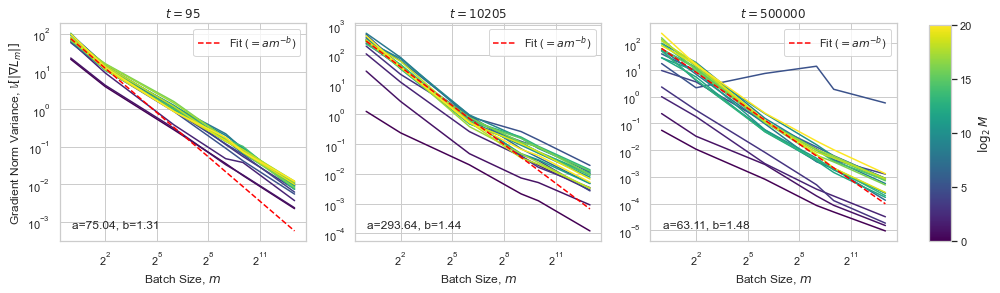

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase

# gradient_norm_variance_t100['grad/norm/mean'] = [p.item() for p in gradient_norm_variance_t100['grad/norm/mean']]
# gradient_norm_variance_t100['grad/norm/std'] = [p.item() for p in gradient_norm_variance_t100['grad/norm/std']]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ts = [min(checkpointer.file_ids, key=lambda x: abs(x-step)) for step in [100, 10_000, 500_000]]

gradient_norm_dfs = dict(zip(ts, [gradient_norm_variance_t100, gradient_norm_variance_t10k, gradient_norm_variance_t500k]))

for (t, grad_norm_df), ax, t_popt in zip(gradient_norm_dfs.items(), axes.flatten(), [t100_popt, t10k_popt, t500k_popt]):
    grad_norm_df["grad/norm/var"] = grad_norm_df["grad/norm/std"] ** 2

    sns.lineplot(
        data=grad_norm_df[grad_norm_df["layer"] == "average"],
        x="batch_size",
        y="grad/norm/var",
        hue="m",
        palette="viridis",
        ax=ax,
        legend=False
    ) 

    # Plot the fit
    # ax.plot(batch_sizes, 10 ** func(np.log2(batch_sizes), *t_popt), color="red", linestyle="--", label="Fit")
    ax.plot(batch_sizes, func(batch_sizes, *t_popt), color="red", linestyle="--", label="Fit ($=am^{-b}$)")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    # ax.set_xticklabels([f"${{{int(np.log2(x))}}}$" for x in ax.get_xticks()])

    ax.set_xlabel(r"Batch Size, $m$")
    ax.set_ylabel(r"Gradient Norm Variance, $\mathbb{V}[|\nabla L_m|]$")
    ax.legend()
    
    ax.set_title(f"$t={t+1}$")

    param_text = f'a={t_popt[0]:.2f}, b={t_popt[1]:.2f}'
    ax.text(0.05, 0.1, param_text, transform=ax.transAxes, verticalalignment='top')

for ax in axes[1:]:
    ax.set_ylabel("")

cbar_ax = fig.add_axes([0.93, 0.125, 0.02, 0.75])  # Adjust as necessary for position and size
# plt.tight_layout()

# Define the colormap
cmap = plt.cm.viridis

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=20), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = [0, 5, 10, 15, 20]  # Positions for each color
tick_labels = map(str, tick_positions)  # Labels for each color
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$\log_2 M$")


In terms of this power law $g_n=am^b$, we get that

$$
am^b \ll \frac{1}{\beta n}.
$$

Plugging in $\beta^*=1/\log n$ and moving terms around, this becomes:

$$
\log_2 m \ll \frac{1}{b}\log_2 \left(\frac{\log n}{2 a n}\right).
$$

<ipython-input-156-180dc6ae37e2>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"$2^{{{int(x)}}}$" for x in ax.get_yticks()])


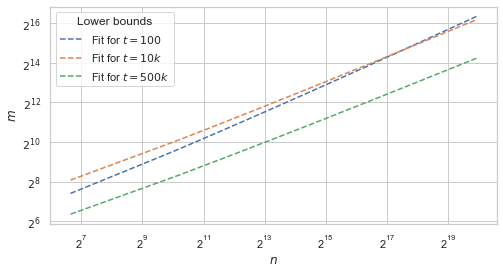

In [ ]:
n = np.linspace(100, 1_000_000, 1000)

def upper_bound(n, a, b):
    return -np.log2( 2 * np.log(n) / (a * n)) / b

fig, ax = plt.subplots(figsize=(8, 4))

for t_label, t_popt in zip(["100", "10k", "500k"], [t100_popt, t10k_popt, t500k_popt]):
    ax.plot(n, upper_bound(n, *t_popt), linestyle="--", label=f"Fit for $t={t_label}$") 

ax.set_yticklabels([f"$2^{{{int(x)}}}$" for x in ax.get_yticks()])
ax.set_xscale("log", base=2)

ax.set_ylabel(r"$m$")
ax.set_xlabel(r"$n$")
ax.legend(title="Lower bounds")

# Garbage Collection

In [ ]:
# Garbage collection
import gc

print(torch.mps.current_allocated_memory() / 1e9)
gc.collect()
torch.mps.empty_cache()  # If you're using a CUDA-enabled GPU
torch.mps.current_allocated_memory() / 1e9

61.045873664


0.0